In [1]:
# Check GPU type
!nvidia-smi

Thu Oct 17 17:33:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   59C    P0             25W /  115W |     369MiB /   6144MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install ultralytics
!pip -q install  ultralytics

In [3]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

# import ipywidgets as widgets
# widgets.IntSlider()


In [4]:
# Path to where your data is stored
DATA_DIR = Path('')

# Preview data files available
os.listdir(DATA_DIR)

['.git',
 '.gitignore',
 'benchmark_submission.csv',
 'cached_images',
 'Code.ipynb',
 'compressed',
 'compress_images.py',
 'custom_cnn_model.pth',
 'custom_cnn_model_epoch_1.pth',
 'custom_cnn_model_epoch_10.pth',
 'custom_cnn_model_epoch_11.pth',
 'custom_cnn_model_epoch_12.pth',
 'custom_cnn_model_epoch_13.pth',
 'custom_cnn_model_epoch_14.pth',
 'custom_cnn_model_epoch_15.pth',
 'custom_cnn_model_epoch_16.pth',
 'custom_cnn_model_epoch_17.pth',
 'custom_cnn_model_epoch_18.pth',
 'custom_cnn_model_epoch_19.pth',
 'custom_cnn_model_epoch_2.pth',
 'custom_cnn_model_epoch_20.pth',
 'custom_cnn_model_epoch_3.pth',
 'custom_cnn_model_epoch_4.pth',
 'custom_cnn_model_epoch_5.pth',
 'custom_cnn_model_epoch_6.pth',
 'custom_cnn_model_epoch_7.pth',
 'custom_cnn_model_epoch_8.pth',
 'custom_cnn_model_epoch_9.pth',
 'custom_cnn_submission.csv',
 'data.yaml',
 'datasets',
 'dataset_errors.log',
 'images',
 'images.zip',
 'LICENSE',
 'pytorch_env',
 'README.md',
 'requirements.txt',
 'runs',
 '

In [5]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')

print(DATASET_DIR)
IMAGES_DIR = DATASET_DIR / 'images/'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

datasets\dataset


In [6]:
# Unzip images to 'images' dir
# shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')

In [7]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)

# Preview the head of the train set
train.head()

Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax            image_path  class_id  
0   208.107730   341.967928  images\id_11543h.jpg         5  
1   162.910362   266.195724  images\id_11543h.jpg         5  
2   252.712993   338.876645  images\id_11543h.jpg         5  
3   238.593750   354.651316  images\id_11543h.jpg         5  
4  2184.252196  1401.748952  images\id_11ee1c.jpg         8

In [8]:
test.head()

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

             image_path  
0  images\id_128pxx.jpg  
1  images\id_12jbci.jpg  
2  images\id_143s4o.jpg  
3  images\id_14tfmb.jpg  
4  images\id_14tw4o.jpg

In [9]:
ss.head()

Image_ID                      class  confidence  ymin  xmin  ymax  \
0  id_128pxx.jpg  Corn_Cercospora_Leaf_Spot         0.5   100   100   100   
1  id_128pxx.jpg           Corn_Common_Rust         0.5   100   100   100   
2  id_128pxx.jpg               Corn_Healthy         0.5   100   100   100   
3  id_128pxx.jpg  Corn_Northern_Leaf_Blight         0.5   100   100   100   
4  id_128pxx.jpg                Corn_Streak         0.5   100   100   100   

   xmax  
0   100  
1   100  
2   100  
3   100  
4   100

In [10]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((30777, 9), (10252, 9))

In [11]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Corn_Cercospora_Leaf_Spot    0.160444
 Tomato_Septoria              0.159047
 Tomato_Late_Blight           0.098905
 Corn_Streak                  0.077201
 Tomato_Healthy               0.069045
 Pepper_Septoria              0.051922
 Pepper_Leaf_Mosaic           0.051662
 Tomato_Early_Blight          0.047763
 Pepper_Bacterial_Spot        0.047665
 Corn_Common_Rust             0.040290
 Pepper_Leaf_Curl             0.037561
 Corn_Healthy                 0.037561
 Tomato_Fusarium              0.019950
 Pepper_Healthy               0.017935
 Pepper_Late_Blight           0.014296
 Pepper_Leaf_Blight           0.012574
 Tomato_Bacterial_Spot        0.011860
 Pepper_Cercospora            0.011405
 Pepper_Fusarium              0.011340
 Tomato_Leaf_Curl             0.011177
 Corn_Northern_Leaf_Blight    0.004289
 Tomato_Mosaic                0.003314
 Pepper_Early_Blight          0.002794
 Name: proportion, dtype: float64,
 class
 Corn_Cercospora_Leaf_Spot    0.156067
 Tomato_Septori

In [12]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [13]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/3676 [00:00<?, ?it/s]

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

In [14]:
X_train.head()

Image_ID  confidence                      class        ymin  \
0  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  194.649671   
1  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  149.632401   
2  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  234.046875   
3  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  221.277138   
6  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  774.562500   

          xmin        ymax         xmax            image_path  class_id  
0   328.803454  208.107730   341.967928  images\id_11543h.jpg         5  
1   256.768914  162.910362   266.195724  images\id_11543h.jpg         5  
2   327.138158  252.712993   338.876645  images\id_11543h.jpg         5  
3   340.411184  238.593750   354.651316  images\id_11543h.jpg         5  
6  2735.933839  850.476742  2834.348725  images\id_11gglx.jpg         0

In [15]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd

# Function to convert the bboxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save annotations for a single image
def save_yolo_annotations_task(image_path, bboxes, output_dir):
    try:
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    try:
        with open(label_file, 'w') as f:
            for bbox in bboxes:
                annotation = convert_to_yolo(bbox, width, height)
                f.write(f"{annotation}\n")
    except Exception as e:
        print(f"Error writing to {label_file}: {e}")

# Function to clear output directory
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to process the dataset and save annotations using ThreadPoolExecutor
def process_dataset(dataframe, output_dir, max_workers=4):
    # Clear the output directory to prevent duplicate annotations
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path'
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Use ThreadPoolExecutor to process tasks
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks to the executor
        futures = [executor.submit(save_yolo_annotations_task, *task) for task in tasks]

        # Use tqdm to display a progress bar as tasks complete
        for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {Path(output_dir).name}"):
            pass  # Progress bar updates as each task completes

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

# import multiprocessing
# from pathlib import Path
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# import shutil
# import pandas as pd

# # Function to convert the bboxes to YOLO format
# def convert_to_yolo(bbox, width, height):
#     ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
#     class_id = bbox['class_id']

#     # Normalize the coordinates
#     x_center = (xmin + xmax) / 2 / width
#     y_center = (ymin + ymax) / 2 / height
#     bbox_width = (xmax - xmin) / width
#     bbox_height = (ymax - ymin) / height

#     return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# # Top-level function to save annotations for a single image
# def save_yolo_annotations_task(task):
#     image_path, bboxes, output_dir = task
#     try:
#         img = np.array(Image.open(str(image_path)))
#         height, width, _ = img.shape
#     except Exception as e:
#         print(f"Error opening image {image_path}: {e}")
#         return

#     label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
#     with open(label_file, 'w') as f:
#         for bbox in bboxes:
#             annotation = convert_to_yolo(bbox, width, height)
#             f.write(f"{annotation}\n")

# # Function to clear output directory
# def clear_output_dir(output_dir):
#     if Path(output_dir).exists():
#         shutil.rmtree(output_dir)
#     Path(output_dir).mkdir(parents=True, exist_ok=True)

# # Function to process the dataset and save annotations
# def process_dataset(dataframe, output_dir):
#     # Clear the output directory to prevent duplicate annotations
#     clear_output_dir(output_dir)

#     # Group the DataFrame by 'image_path'
#     grouped = dataframe.groupby('image_path')
#     tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

#     # Use multiprocessing Pool to process tasks
#     with multiprocessing.Pool() as pool:
#         list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


# # Save train and validation labels to their respective dirs
# process_dataset(X_train, TRAIN_LABELS_DIR)
# process_dataset(X_val, VAL_LABELS_DIR)

Processing val: 100%|██████████| 1226/1226 [00:26<00:00, 45.55it/s]


In [16]:
# Train images dir
TRAIN_IMAGES_DIR

WindowsPath('datasets/dataset/images/train')

In [17]:
print(str(TRAIN_IMAGES_DIR))

datasets\dataset\images\train


In [18]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/' + str(TRAIN_IMAGES_DIR),
    'val': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/' + str(VAL_IMAGES_DIR),
    'test': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\\dataset\\images\\train',
 'val': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\\dataset\\images\\val',
 'test': 'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\\dataset\\images\\test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_11543h.jpg with 4 bounding boxes.


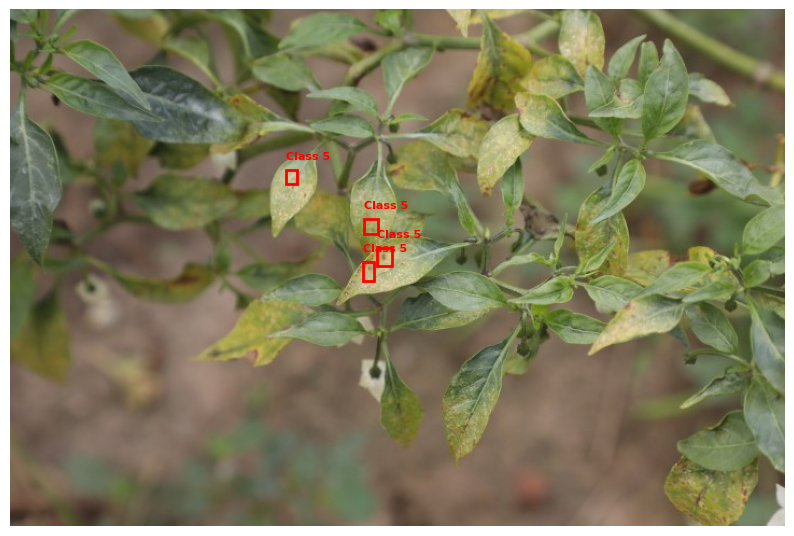

Plotting id_11gglx.jpg with 11 bounding boxes.


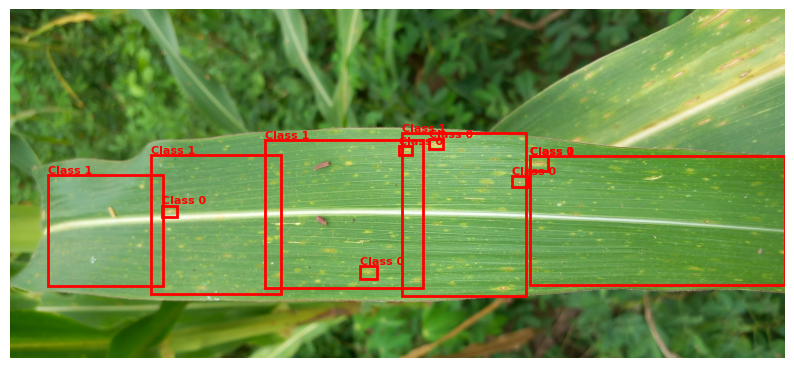

Plotting id_11zffz.jpg with 10 bounding boxes.


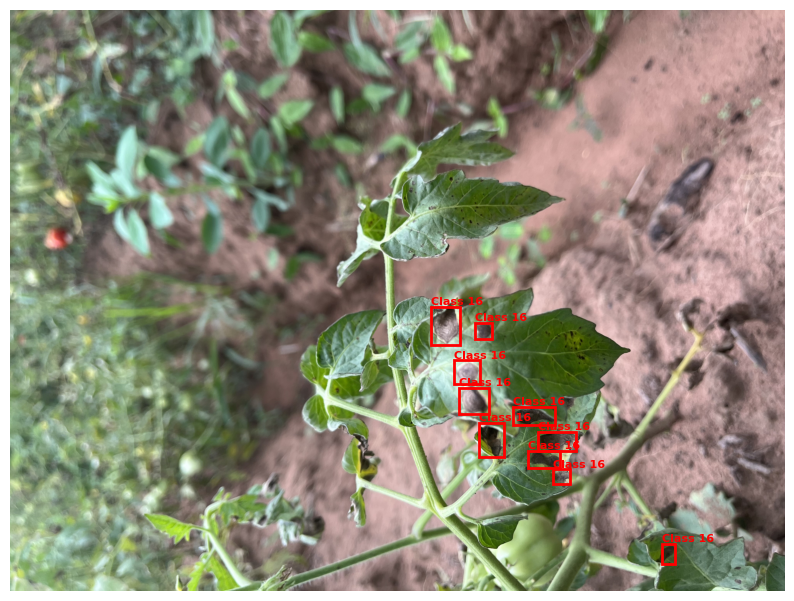

Plotting id_127uhh.jpg with 1 bounding boxes.


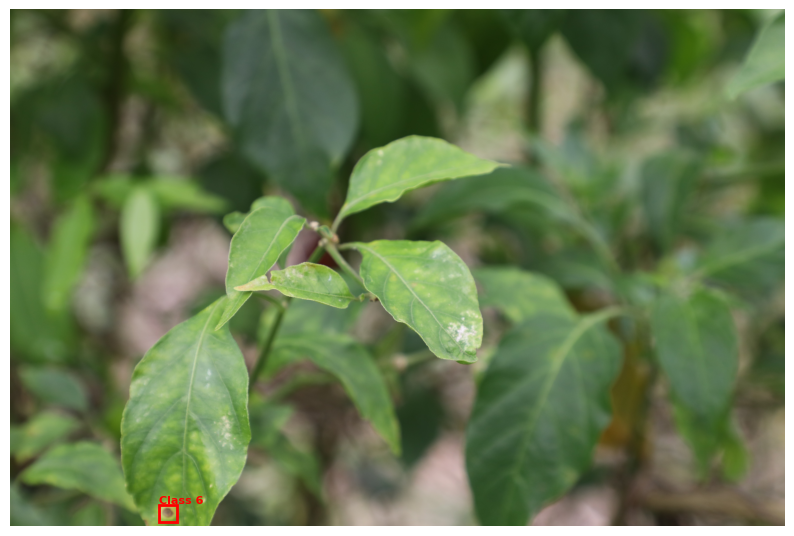

Plotting id_12q33h.jpg with 3 bounding boxes.


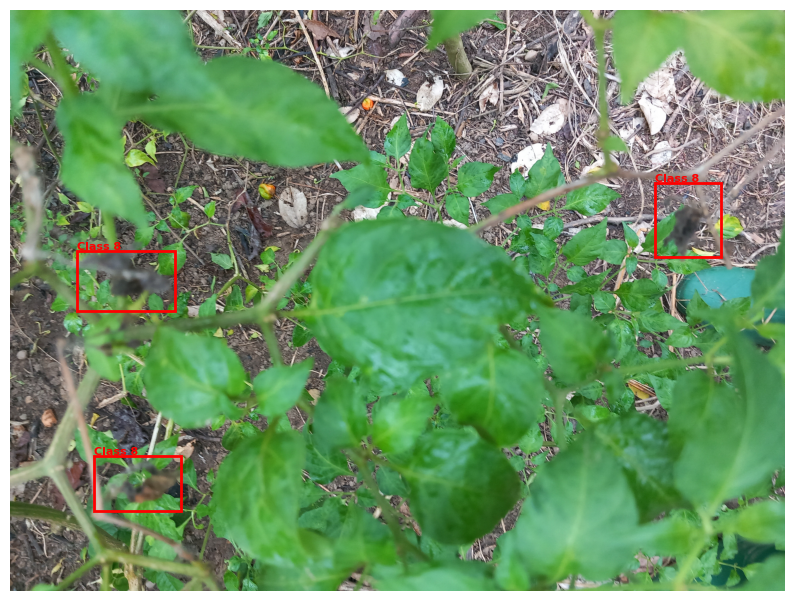

In [19]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [20]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of CUDA Devices:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")


PyTorch Version: 2.0.1+cu117
CUDA Available: True
Number of CUDA Devices: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [21]:
# import pandas as pd
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F
# from PIL import Image
# from tqdm import tqdm
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import torchvision.transforms as transforms

# # -----------------------------
# # 1. Setup and Configuration
# # -----------------------------

# # Set device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Paths
# train_csv_path = 'Train.csv'  # Path to your training CSV
# images_dir = 'datasets/dataset/images/train'  # Path to your images directory
# model_weights_path = 'custom_cnn_model.pth'  # Path to save/load your model weights

# # -----------------------------
# # 2. Data Preparation
# # -----------------------------

# # Load train data
# train = pd.read_csv(train_csv_path)

# # Encode class labels into numerical format using LabelEncoder
# label_encoder = LabelEncoder()
# train['class'] = label_encoder.fit_transform(train['class'])

# # Check for missing image files and filter them out
# valid_images = [img_id for img_id in train['Image_ID'] if os.path.exists(os.path.join(images_dir, img_id))]
# train = train[train['Image_ID'].isin(valid_images)].reset_index(drop=True)

# print(f"Number of training samples after filtering: {len(train)}")

# # Split data into training and validation sets (80% train, 20% val)
# train_df, val_df = train_test_split(
#     train, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=train['class']
# )

# print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# # -----------------------------
# # 3. Dataset and DataLoader
# # -----------------------------

# # Define a Custom Dataset Class for Loading Images and Annotations
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, images_dir, transforms=None):
#         self.dataframe = dataframe
#         self.images_dir = images_dir
#         self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         image_id = self.dataframe.iloc[idx]['Image_ID']
#         image_path = os.path.join(self.images_dir, image_id)
        
#         # Load and preprocess the image
#         try:
#             image = Image.open(image_path).convert("RGB")
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")
#             return None, None  # Return None if the image cannot be opened
        
#         # Extract bounding box coordinates
#         bbox = torch.tensor(
#             [self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']], 
#             dtype=torch.float32
#         )
        
#         # Extract class label
#         label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
#         # Apply transformations
#         if self.transforms:
#             image = self.transforms(image)
        
#         return image, {'boxes': bbox, 'labels': label}

# # Define transformations for the images
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize images to 256x256
#     transforms.ToTensor()
# ])

# # Instantiate the training dataset and DataLoader
# train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transforms=transform)
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=32,          # Adjust based on your GPU memory
#     shuffle=True,           # Shuffle for training
#     num_workers=4,          # Number of subprocesses for data loading
#     pin_memory=True         # Copy tensors into CUDA pinned memory
# )

# # Instantiate the validation dataset and DataLoader
# val_dataset = CustomDataset(dataframe=val_df, images_dir=images_dir, transforms=transform)
# val_loader = DataLoader(
#     val_dataset, 
#     batch_size=32,          # Adjust based on your GPU memory
#     shuffle=False,          # No need to shuffle for evaluation
#     num_workers=4,          # Number of subprocesses for data loading
#     pin_memory=True         # Copy tensors into CUDA pinned memory
# )

# # -----------------------------
# # 4. Model Definition
# # -----------------------------

# # Define the CustomCNN model
# class CustomCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.flattened_size = self._get_flattened_size()
#         self.fc1 = nn.Linear(self.flattened_size, 256)
#         self.fc2_bbox = nn.Linear(256, 4)      # Bounding box coordinates [xmin, ymin, xmax, ymax]
#         self.fc2_class = nn.Linear(256, num_classes)  # Class prediction

#     def _get_flattened_size(self):
#         dummy_input = torch.zeros(1, 3, 256, 256)
#         dummy_output = self._forward_conv(dummy_input)
#         return dummy_output.view(1, -1).size(1)

#     def _forward_conv(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         return x

#     def forward(self, x):
#         x = self._forward_conv(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         bbox_output = self.fc2_bbox(x)
#         class_output = self.fc2_class(x)
#         return bbox_output, class_output

# # Define number of classes based on unique labels
# num_classes = len(train['class'].unique())

# # Instantiate the model and move to the correct device
# model = CustomCNN(num_classes=num_classes).to(device)

# # Print the model structure (optional)
# print(f"Custom CNN Model:\n{model}")

# # -----------------------------
# # 5. Training Loop
# # -----------------------------

# # Define loss functions and optimizer
# bbox_loss_fn = nn.MSELoss()
# class_loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 3
# for epoch in range(num_epochs):
#     print(f"\nStarting Epoch {epoch + 1}/{num_epochs}")
#     model.train()
#     total_bbox_loss, total_class_loss = 0.0, 0.0

#     for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc="Training")):
#         if images is None or targets is None:
#             print(f"Skipping batch {batch_idx + 1} due to None values.")
#             continue

#         # Move data to the correct device
#         images = images.to(device)
#         bboxes = targets['boxes'].to(device)
#         labels = targets['labels'].to(device)

#         # Forward pass
#         pred_bboxes, pred_labels = model(images)

#         # Calculate losses
#         bbox_loss = bbox_loss_fn(pred_bboxes, bboxes)
#         class_loss = class_loss_fn(pred_labels, labels)
#         total_loss = bbox_loss + class_loss

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         # Accumulate losses
#         total_bbox_loss += bbox_loss.item()
#         total_class_loss += class_loss.item()

#     avg_bbox_loss = total_bbox_loss / len(train_loader)
#     avg_class_loss = total_class_loss / len(train_loader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], BBox Loss: {avg_bbox_loss:.4f}, Class Loss: {avg_class_loss:.4f}')

# # Save the trained model
# torch.save(model.state_dict(), model_weights_path)
# print(f"\nModel saved to '{model_weights_path}'")

# # -----------------------------
# # 6. Evaluation Metrics
# # -----------------------------

# def calculate_iou(box1, box2):
#     """
#     Calculate Intersection over Union (IoU) between two bounding boxes.
#     Boxes are in the format [xmin, ymin, xmax, ymax]
#     """
#     x_left = max(box1[0], box2[0])
#     y_top    = max(box1[1], box2[1])
#     x_right  = min(box1[2], box2[2])
#     y_bottom = min(box1[3], box2[3])

#     if x_right < x_left or y_bottom < y_top:
#         return 0.0  # No overlap

#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
#     box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
#     iou = intersection_area / float(box1_area + box2_area - intersection_area)
#     return iou

# def evaluate_classification(model, dataloader, device):
#     """
#     Evaluate classification performance: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
#     """
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Evaluating Classification"):
#             # Handle possible None batches
#             if images is None or targets is None:
#                 continue

#             images = images.to(device)
#             labels = targets['labels'].to(device)

#             # Forward pass
#             _, preds = model(images)  # Assuming model returns (bbox, class)
#             preds = torch.argmax(preds, dim=1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Calculate metrics
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision, recall, f1, _ = precision_recall_fscore_support(
#         all_labels, all_preds, average='weighted', zero_division=0
#     )
#     conf_matrix = confusion_matrix(all_labels, all_preds)
# #
#     print("\n--- Classification Evaluation ---")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision (Weighted): {precision:.4f}")
#     print(f"Recall (Weighted): {recall:.4f}")
#     print(f"F1-Score (Weighted): {f1:.4f}")
#     print("Confusion Matrix:")
#     print(conf_matrix)

# def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
#     """
#     Evaluate bounding box predictions: Mean IoU and Precision at IoU threshold
#     """
#     model.eval()
#     all_iou = []
#     matched = 0
#     total = 0

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Evaluating Bounding Boxes"):
#             # Handle possible None batches
#             if images is None or targets is None:
#                 continue

#             images = images.to(device)
#             true_bboxes = targets['boxes'].to(device)

#             # Forward pass
#             pred_bboxes, _ = model(images)

#             # Move tensors to CPU for processing
#             pred_bboxes = pred_bboxes.cpu().numpy()
#             true_bboxes = true_bboxes.cpu().numpy()

#             # Iterate over each prediction and true box
#             for pred_box, true_box in zip(pred_bboxes, true_bboxes):
#                 iou = calculate_iou(pred_box, true_box)
#                 all_iou.append(iou)
#                 if iou >= iou_threshold:
#                     matched += 1
#                 total += 1

#     # Calculate metrics
#     mean_iou = np.mean(all_iou) if all_iou else 0
#     precision_at_iou = matched / total if total > 0 else 0

#     print("\n--- Bounding Box Evaluation ---")
#     print(f"Mean IoU: {mean_iou:.4f}")
#     print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

# def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
#     """
#     Visualize a few samples of ground truth and predicted bounding boxes along with class labels
#     """
#     model.eval()
#     samples_visualized = 0

#     with torch.no_grad():
#         for images, targets in dataloader:
#             # Handle possible None batches
#             if images is None or targets is None:
#                 continue

#             images = images.to(device)
#             true_bboxes = targets['boxes'].to(device)
#             true_labels = targets['labels'].to(device)

#             # Forward pass
#             pred_bboxes, pred_labels = model(images)
#             preds = torch.argmax(pred_labels, dim=1)

#             # Move tensors to CPU for visualization
#             images = images.cpu().numpy()
#             true_bboxes = true_bboxes.cpu().numpy()
#             preds = preds.cpu().numpy()
#             pred_bboxes = pred_bboxes.cpu().numpy()

#             for img, true_box, true_label, pred_box, pred_label in zip(
#                 images, true_bboxes, true_labels, pred_bboxes, preds
#             ):
#                 if samples_visualized >= num_samples:
#                     return

#                 fig, ax = plt.subplots(1)
#                 img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
#                 ax.imshow(img)

#                 # Plot Ground Truth Bounding Box
#                 gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
#                 gt_width = gt_xmax - gt_xmin
#                 gt_height = gt_ymax - gt_ymin
#                 gt_rect = patches.Rectangle(
#                     (gt_xmin, gt_ymin), gt_width, gt_height, 
#                     linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
#                 )
#                 ax.add_patch(gt_rect)

#                 # Plot Predicted Bounding Box
#                 pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
#                 pred_width = pred_xmax - pred_xmin
#                 pred_height = pred_ymax - pred_ymin
#                 pred_rect = patches.Rectangle(
#                     (pred_xmin, pred_ymin), pred_width, pred_height, 
#                     linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
#                 )
#                 ax.add_patch(pred_rect)

#                 # Add Labels
#                 gt_class = label_encoder.inverse_transform([true_label])[0]
#                 pred_class = label_encoder.inverse_transform([pred_label])[0]
#                 plt.title(f"GT: {gt_class} | Pred: {pred_class}")

#                 # Create Legend
#                 handles = [
#                     patches.Patch(color='g', label='Ground Truth'),
#                     patches.Patch(color='r', label='Prediction')
#                 ]
#                 plt.legend(handles=handles)

#                 plt.show()

#                 samples_visualized += 1

# # -----------------------------
# # 7. Model Evaluation
# # -----------------------------

# # Load the trained model weights (already saved in 'custom_cnn_model.pth')
# if os.path.exists(model_weights_path):
#     model.load_state_dict(torch.load(model_weights_path, map_location=device))
#     model.eval()  # Set model to evaluation mode
#     print(f"\nModel loaded from '{model_weights_path}' and set to evaluation mode.")
# else:
#     print(f"\nModel weights file '{model_weights_path}' not found. Please ensure the file exists.")
#     # Optionally, exit the script or proceed without evaluation
#     exit()

# # Evaluate Classification
# evaluate_classification(model, val_loader, device)

# # Evaluate Bounding Boxes
# evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

# # Visualize Predictions (Optional)
# visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)


In [22]:
# import pandas as pd
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F
# from PIL import Image
# from tqdm import tqdm
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import torchvision.transforms as transforms

# # -----------------------------
# # 1. Setup and Configuration
# # -----------------------------

# # Set device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Paths
# train_csv_path = 'Train.csv'  # Path to your training CSV
# images_dir = 'datasets/dataset/images/train'  # Path to your images directory
# model_weights_path = 'custom_cnn_model.pth'  # Path to save/load your model weights

# # -----------------------------
# # 2. Data Preparation
# # -----------------------------

# # Load train data
# train = pd.read_csv(train_csv_path)

# # Encode class labels into numerical format using LabelEncoder
# label_encoder = LabelEncoder()
# train['class'] = label_encoder.fit_transform(train['class'])

# # Check for missing image files and filter them out
# valid_images = [img_id for img_id in train['Image_ID'] if os.path.exists(os.path.join(images_dir, img_id))]
# train = train[train['Image_ID'].isin(valid_images)].reset_index(drop=True)

# print(f"Number of training samples after filtering: {len(train)}")

# # Split data into training and validation sets (80% train, 20% val)
# train_df, val_df = train_test_split(
#     train, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=train['class']
# )

# print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# # -----------------------------
# # 3. Dataset and DataLoader
# # -----------------------------

# # Define a Custom Dataset Class for Loading Images and Annotations
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, images_dir, transforms=None):
#         self.dataframe = dataframe
#         self.images_dir = images_dir
#         self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         image_id = self.dataframe.iloc[idx]['Image_ID']
#         image_path = os.path.join(self.images_dir, image_id)
        
#         # Load and preprocess the image
#         try:
#             image = Image.open(image_path).convert("RGB")
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {image_path}: {e}")
        
#         # Extract bounding box coordinates
#         bbox = torch.tensor(
#             [self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']], 
#             dtype=torch.float32
#         )
        
#         # Extract class label
#         label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
#         # Apply transformations
#         if self.transforms:
#             image = self.transforms(image)
        
#         return image, {'boxes': bbox, 'labels': label}

# # Define transformations for the images
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize images to 256x256
#     transforms.ToTensor()
# ])

# # Instantiate the training dataset and DataLoader
# train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transforms=transform)
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=16,          # Adjust based on your GPU memory
#     shuffle=True,           # Shuffle for training
#     num_workers=0,          # Set to 0 for easier debugging
#     pin_memory=True         # Copy tensors into CUDA pinned memory
# )

# # Instantiate the validation dataset and DataLoader
# val_dataset = CustomDataset(dataframe=val_df, images_dir=images_dir, transforms=transform)
# val_loader = DataLoader(
#     val_dataset, 
#     batch_size=16,          # Adjust based on your GPU memory
#     shuffle=False,          # No need to shuffle for evaluation
#     num_workers=0,          # Set to 0 for easier debugging
#     pin_memory=True         # Copy tensors into CUDA pinned memory
# )

# # -----------------------------
# # 4. Model Definition
# # -----------------------------

# # Define the CustomCNN model
# class CustomCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.flattened_size = self._get_flattened_size()
#         self.fc1 = nn.Linear(self.flattened_size, 256)
#         self.fc2_bbox = nn.Linear(256, 4)      # Bounding box coordinates [xmin, ymin, xmax, ymax]
#         self.fc2_class = nn.Linear(256, num_classes)  # Class prediction

#     def _get_flattened_size(self):
#         dummy_input = torch.zeros(1, 3, 256, 256)
#         dummy_output = self._forward_conv(dummy_input)
#         return dummy_output.view(1, -1).size(1)

#     def _forward_conv(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         return x

#     def forward(self, x):
#         x = self._forward_conv(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         bbox_output = self.fc2_bbox(x)
#         class_output = self.fc2_class(x)
#         return bbox_output, class_output

# # Define number of classes based on unique labels
# num_classes = len(train['class'].unique())

# # Instantiate the model and move to the correct device
# model = CustomCNN(num_classes=num_classes).to(device)

# # Print the model structure (optional)
# print(f"Custom CNN Model:\n{model}")

# # -----------------------------
# # 5. Training Loop
# # -----------------------------

# # Define loss functions and optimizer
# bbox_loss_fn = nn.MSELoss()
# class_loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 1
# for epoch in range(num_epochs):
#     print(f"\nStarting Epoch {epoch + 1}/{num_epochs}")
#     model.train()
#     total_bbox_loss, total_class_loss = 0.0, 0.0

#     for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc="Training")):
#         # Skip batches where images or targets are None
#         if images is None or targets is None:
#             print(f"Skipping batch {batch_idx + 1} due to None values.")
#             continue

#         # Move data to the correct device
#         images = images.to(device)
#         bboxes = targets['boxes'].to(device)
#         labels = targets['labels'].to(device)

#         # Forward pass
#         pred_bboxes, pred_labels = model(images)

#         # Calculate losses
#         bbox_loss = bbox_loss_fn(pred_bboxes, bboxes)
#         class_loss = class_loss_fn(pred_labels, labels)
#         total_loss = bbox_loss + class_loss

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         # Accumulate losses
#         total_bbox_loss += bbox_loss.item()
#         total_class_loss += class_loss.item()

#     avg_bbox_loss = total_bbox_loss / len(train_loader)
#     avg_class_loss = total_class_loss / len(train_loader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], BBox Loss: {avg_bbox_loss:.4f}, Class Loss: {avg_class_loss:.4f}')

# # Save the trained model
# torch.save(model.state_dict(), model_weights_path)
# print(f"\nModel saved to '{model_weights_path}'")

# # -----------------------------
# # 6. Evaluation Metrics
# # -----------------------------

# def calculate_iou(box1, box2):
#     """
#     Calculate Intersection over Union (IoU) between two bounding boxes.
#     Boxes are in the format [xmin, ymin, xmax, ymax]
#     """
#     x_left = max(box1[0], box2[0])
#     y_top    = max(box1[1], box2[1])
#     x_right  = min(box1[2], box2[2])
#     y_bottom = min(box1[3], box2[3])

#     if x_right < x_left or y_bottom < y_top:
#         return 0.0  # No overlap

#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
#     box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
#     iou = intersection_area / float(box1_area + box2_area - intersection_area)
#     return iou

# def evaluate_classification(model, dataloader, device):
#     """
#     Evaluate classification performance: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
#     """
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Evaluating Classification"):
#             # Skip batches where images or targets are None
#             if images is None or targets is None:
#                 continue

#             images = images.to(device)
#             labels = targets['labels'].to(device)

#             # Forward pass
#             _, preds = model(images)  # Assuming model returns (bbox, class)
#             preds = torch.argmax(preds, dim=1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Calculate metrics
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision, recall, f1, _ = precision_recall_fscore_support(
#         all_labels, all_preds, average='weighted', zero_division=0
#     )
#     conf_matrix = confusion_matrix(all_labels, all_preds)

#     print("\n--- Classification Evaluation ---")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision (Weighted): {precision:.4f}")
#     print(f"Recall (Weighted): {recall:.4f}")
#     print(f"F1-Score (Weighted): {f1:.4f}")
#     print("Confusion Matrix:")
#     print(conf_matrix)

# def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
#     """
#     Evaluate bounding box predictions: Mean IoU and Precision at IoU threshold
#     """
#     model.eval()
#     all_iou = []
#     matched = 0
#     total = 0

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Evaluating Bounding Boxes"):
#             # Skip batches where images or targets are None
#             if images is None or targets is None:
#                 continue

#             images = images.to(device)
#             true_bboxes = targets['boxes'].to(device)

#             # Forward pass
#             pred_bboxes, _ = model(images)

#             # Move tensors to CPU for processing
#             pred_bboxes = pred_bboxes.cpu().numpy()
#             true_bboxes = true_bboxes.cpu().numpy()

#             # Iterate over each prediction and true box
#             for pred_box, true_box in zip(pred_bboxes, true_bboxes):
#                 iou = calculate_iou(pred_box, true_box)
#                 all_iou.append(iou)
#                 if iou >= iou_threshold:
#                     matched += 1
#                 total += 1

#     # Calculate metrics
#     mean_iou = np.mean(all_iou) if all_iou else 0
#     precision_at_iou = matched / total if total > 0 else 0

#     print("\n--- Bounding Box Evaluation ---")
#     print(f"Mean IoU: {mean_iou:.4f}")
#     print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

# def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
#     """
#     Visualize a few samples of ground truth and predicted bounding boxes along with class labels
#     """
#     model.eval()
#     samples_visualized = 0

#     with torch.no_grad():
#         for images, targets in dataloader:
#             # Skip batches where images or targets are None
#             if images is None or targets is None:
#                 continue

#             images = images.to(device)
#             true_bboxes = targets['boxes'].to(device)
#             true_labels = targets['labels'].to(device)

#             # Forward pass
#             pred_bboxes, pred_labels = model(images)
#             preds = torch.argmax(pred_labels, dim=1)

#             # Move tensors to CPU for visualization
#             images = images.cpu().numpy()
#             true_bboxes = true_bboxes.cpu().numpy()
#             preds = preds.cpu().numpy()
#             pred_bboxes = pred_bboxes.cpu().numpy()

#             for img, true_box, true_label, pred_box, pred_label in zip(
#                 images, true_bboxes, true_labels, pred_bboxes, preds
#             ):
#                 if samples_visualized >= num_samples:
#                     return

#                 fig, ax = plt.subplots(1)
#                 img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
#                 ax.imshow(img)

#                 # Plot Ground Truth Bounding Box
#                 gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
#                 gt_width = gt_xmax - gt_xmin
#                 gt_height = gt_ymax - gt_ymin
#                 gt_rect = patches.Rectangle(
#                     (gt_xmin, gt_ymin), gt_width, gt_height, 
#                     linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
#                 )
#                 ax.add_patch(gt_rect)

#                 # Plot Predicted Bounding Box
#                 pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
#                 pred_width = pred_xmax - pred_xmin
#                 pred_height = pred_ymax - pred_ymin
#                 pred_rect = patches.Rectangle(
#                     (pred_xmin, pred_ymin), pred_width, pred_height, 
#                     linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
#                 )
#                 ax.add_patch(pred_rect)

#                 # Add Labels
#                 gt_class = label_encoder.inverse_transform([true_label])[0]
#                 pred_class = label_encoder.inverse_transform([pred_label])[0]
#                 plt.title(f"GT: {gt_class} | Pred: {pred_class}")

#                 # Create Legend
#                 handles = [
#                     patches.Patch(color='g', label='Ground Truth'),
#                     patches.Patch(color='r', label='Prediction')
#                 ]
#                 plt.legend(handles=handles)

#                 plt.show()

#                 samples_visualized += 1

# # -----------------------------
# # 7. Model Evaluation
# # -----------------------------

# # Load the trained model weights (already saved in 'custom_cnn_model.pth')
# if os.path.exists(model_weights_path):
#     try:
#         model.load_state_dict(torch.load(model_weights_path, map_location=device))
#         model.eval()  # Set model to evaluation mode
#         print(f"\nModel loaded from '{model_weights_path}' and set to evaluation mode.")
#     except Exception as e:
#         print(f"\nError loading model weights: {e}")
#         exit()
# else:
#     print(f"\nModel weights file '{model_weights_path}' not found. Please ensure the file exists.")
#     exit()

# # Evaluate Classification
# evaluate_classification(model, val_loader, device)

# # Evaluate Bounding Boxes
# evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

# # Visualize Predictions (Optional)
# visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)


In [23]:
# # import pandas as pd
# # import os
# # import torch
# # import torch.nn as nn
# # import torch.optim as optim
# # from torch.utils.data import Dataset, DataLoader
# # import torch.nn.functional as F
# # from PIL import Image
# # from tqdm import tqdm
# # from sklearn.preprocessing import LabelEncoder
# # from sklearn.model_selection import train_test_split
# # from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# # import numpy as np
# # import matplotlib.pyplot as plt
# # import matplotlib.patches as patches
# # import torchvision.transforms as transforms

# # # -----------------------------
# # # 1. Setup and Configuration
# # # -----------------------------

# # # Set device to GPU if available
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # print(f"Using device: {device}")

# # # Paths
# # train_csv_path = 'Train.csv'  # Path to your training CSV
# # images_dir = 'datasets/dataset/images/compressed/train'  # Path to your images directory
# # model_weights_path = 'custom_cnn_model.pth'  # Path to save/load your model weights

# # # -----------------------------
# # # 2. Data Preparation
# # # -----------------------------

# # # Load train data
# # train = pd.read_csv(train_csv_path)

# # # Encode class labels into numerical format using LabelEncoder
# # label_encoder = LabelEncoder()
# # train['class'] = label_encoder.fit_transform(train['class'])

# # # Check for missing image files and filter them out
# # valid_images = [img_id for img_id in train['Image_ID'] if os.path.exists(os.path.join(images_dir, img_id))]
# # train = train[train['Image_ID'].isin(valid_images)].reset_index(drop=True)

# # print(f"Number of training samples after filtering: {len(train)}")

# # # Split data into training and validation sets (80% train, 20% val)
# # train_df, val_df = train_test_split(
# #     train, 
# #     test_size=0.2, 
# #     random_state=42, 
# #     stratify=train['class']
# # )

# # print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# # # -----------------------------
# # # 3. Dataset and DataLoader
# # # -----------------------------

# # # Define a Custom Dataset Class for Loading Images and Annotations
# # class CustomDataset(Dataset):
# #     def __init__(self, dataframe, images_dir, transforms=None):
# #         self.dataframe = dataframe
# #         self.images_dir = images_dir
# #         self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])

# #     def __len__(self):
# #         return len(self.dataframe)

# #     def __getitem__(self, idx):
# #         image_id = self.dataframe.iloc[idx]['Image_ID']
# #         image_path = os.path.join(self.images_dir, image_id)
        
# #         # Load and preprocess the image
# #         try:
# #             image = Image.open(image_path).convert("RGB")
# #         except Exception as e:
# #             raise RuntimeError(f"Error loading image {image_path}: {e}")
        
# #         # Extract bounding box coordinates
# #         bbox = torch.tensor(
# #             [self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']], 
# #             dtype=torch.float32
# #         )
        
# #         # Extract class label
# #         label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
# #         # Apply transformations
# #         if self.transforms:
# #             image = self.transforms(image)
        
# #         return image, {'boxes': bbox, 'labels': label}

# # # Define transformations for the images
# # transform = transforms.Compose([
# #     transforms.Resize((256, 256)),  # Resize images to 256x256
# #     transforms.ToTensor(),
# #     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
# #                          std=[0.229, 0.224, 0.225])   # ImageNet std
# # ])

# # # Instantiate the training dataset and DataLoader
# # train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transforms=transform)
# # train_loader = DataLoader(
# #     train_dataset, 
# #     batch_size=32,          # Adjust based on your GPU memory
# #     shuffle=True,           # Shuffle for training
# #     num_workers=0,          # Set to 0 for easier debugging
# #     pin_memory=True         # Copy tensors into CUDA pinned memory
# # )

# # # Instantiate the validation dataset and DataLoader
# # val_dataset = CustomDataset(dataframe=val_df, images_dir=images_dir, transforms=transform)
# # val_loader = DataLoader(
# #     val_dataset, 
# #     batch_size=32,          # Adjust based on your GPU memory
# #     shuffle=False,          # No need to shuffle for evaluation
# #     num_workers=0,          # Set to 0 for easier debugging
# #     pin_memory=True         # Copy tensors into CUDA pinned memory
# # )

# # # -----------------------------
# # # 4. Model Definition
# # # -----------------------------

# # # Define the CustomCNN model
# # class CustomCNN(nn.Module):
# #     def __init__(self, num_classes):
# #         super(CustomCNN, self).__init__()
# #         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
# #         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
# #         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
# #         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
# #         self.flattened_size = self._get_flattened_size()
# #         self.fc1 = nn.Linear(self.flattened_size, 256)
# #         self.fc2_bbox = nn.Linear(256, 4)      # Bounding box coordinates [xmin, ymin, xmax, ymax]
# #         self.fc2_class = nn.Linear(256, num_classes)  # Class prediction

# #     def _get_flattened_size(self):
# #         dummy_input = torch.zeros(1, 3, 256, 256)
# #         dummy_output = self._forward_conv(dummy_input)
# #         return dummy_output.view(1, -1).size(1)

# #     def _forward_conv(self, x):
# #         x = self.pool(F.relu(self.conv1(x)))
# #         x = self.pool(F.relu(self.conv2(x)))
# #         x = self.pool(F.relu(self.conv3(x)))
# #         return x

# #     def forward(self, x):
# #         x = self._forward_conv(x)
# #         x = x.view(x.size(0), -1)
# #         x = F.relu(self.fc1(x))
# #         bbox_output = self.fc2_bbox(x)
# #         class_output = self.fc2_class(x)
# #         return bbox_output, class_output

# # # Define number of classes based on unique labels
# # num_classes = len(train['class'].unique())

# # # Instantiate the model and move to the correct device
# # model = CustomCNN(num_classes=num_classes).to(device)

# # # Print the model structure (optional)
# # print(f"Custom CNN Model:\n{model}")

# # # -----------------------------
# # # 5. Training Loop
# # # -----------------------------

# # # Define loss functions and optimizer

# # # IoU Loss Function
# # class IoULoss(nn.Module):
# #     def __init__(self):
# #         super(IoULoss, self).__init__()

# #     def forward(self, pred_boxes, target_boxes):
# #         # Convert boxes from (xmin, ymin, xmax, ymax) to (x1, y1, x2, y2)
# #         pred_boxes = torch.sigmoid(pred_boxes)  # Ensure predictions are between 0 and 1
# #         target_boxes = torch.sigmoid(target_boxes)
        
# #         # Intersection coordinates
# #         x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
# #         y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
# #         x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
# #         y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])
        
# #         # Intersection area
# #         intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
        
# #         # Areas of the boxes
# #         pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]).clamp(min=0) * \
# #                     (pred_boxes[:, 3] - pred_boxes[:, 1]).clamp(min=0)
# #         target_area = (target_boxes[:, 2] - target_boxes[:, 0]).clamp(min=0) * \
# #                       (target_boxes[:, 3] - target_boxes[:, 1]).clamp(min=0)
        
# #         # Union area
# #         union = pred_area + target_area - intersection + 1e-6  # Add epsilon to prevent division by zero
        
# #         # IoU
# #         iou = intersection / union
        
# #         # IoU Loss
# #         loss = 1 - iou
# #         return loss.mean()

# # # Initialize IoU Loss
# # iou_loss_fn = IoULoss()

# # # Cross Entropy Loss for classification
# # class_loss_fn = nn.CrossEntropyLoss()

# # # Optimizer
# # optimizer = optim.Adam(model.parameters(), lr=0.001)

# # # Learning Rate Scheduler (Optional)
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# # # Training loop with validation
# # num_epochs = 1  # Increased from 1 to 5

# # for epoch in range(num_epochs):
# #     print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
# #     model.train()
# #     total_iou_loss, total_class_loss = 0.0, 0.0
# #     train_loader_iter = tqdm(train_loader, desc="Training", leave=False)
    
# #     for batch_idx, (images, targets) in enumerate(train_loader_iter):
# #         # Skip batches where images or targets are None
# #         if images is None or targets is None:
# #             print(f"Skipping batch {batch_idx + 1} due to None values.")
# #             continue

# #         # Move data to the correct device
# #         images = images.to(device)
# #         bboxes = targets['boxes'].to(device)
# #         labels = targets['labels'].to(device)

# #         # Forward pass
# #         pred_bboxes, pred_labels = model(images)

# #         # Calculate losses
# #         bbox_loss = iou_loss_fn(pred_bboxes, bboxes)
# #         class_loss = class_loss_fn(pred_labels, labels)
# #         total_loss = bbox_loss + class_loss

# #         # Backward pass and optimization
# #         optimizer.zero_grad()
# #         total_loss.backward()
# #         optimizer.step()

# #         # Accumulate losses
# #         total_iou_loss += bbox_loss.item()
# #         total_class_loss += class_loss.item()

# #         # Update progress bar
# #         train_loader_iter.set_postfix({'IoU Loss': bbox_loss.item(), 'Class Loss': class_loss.item()})

# #     avg_iou_loss = total_iou_loss / len(train_loader)
# #     avg_class_loss = total_class_loss / len(train_loader)
# #     print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

# #     # Step the scheduler
# #     scheduler.step()

# #     # -----------------------------
# #     # 6. Validation After Each Epoch
# #     # -----------------------------

# #     def calculate_iou(box1, box2):
# #         """
# #         Calculate Intersection over Union (IoU) between two bounding boxes.
# #         Boxes are in the format [xmin, ymin, xmax, ymax]
# #         """
# #         x_left = max(box1[0], box2[0])
# #         y_top    = max(box1[1], box2[1])
# #         x_right  = min(box1[2], box2[2])
# #         y_bottom = min(box1[3], box2[3])

# #         if x_right < x_left or y_bottom < y_top:
# #             return 0.0  # No overlap

# #         intersection_area = (x_right - x_left) * (y_bottom - y_top)
# #         box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
# #         box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
# #         iou = intersection_area / float(box1_area + box2_area - intersection_area)
# #         return iou

# #     def evaluate_classification(model, dataloader, device):
# #         """
# #         Evaluate classification performance: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
# #         """
# #         model.eval()
# #         all_preds = []
# #         all_labels = []

# #         with torch.no_grad():
# #             for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
# #                 # Skip batches where images or targets are None
# #                 if images is None or targets is None:
# #                     continue

# #                 images = images.to(device)
# #                 labels = targets['labels'].to(device)

# #                 # Forward pass
# #                 _, preds = model(images)  # Assuming model returns (bbox, class)
# #                 preds = torch.argmax(preds, dim=1)

# #                 all_preds.extend(preds.cpu().numpy())
# #                 all_labels.extend(labels.cpu().numpy())

# #         # Calculate metrics
# #         accuracy = accuracy_score(all_labels, all_preds)
# #         precision, recall, f1, _ = precision_recall_fscore_support(
# #             all_labels, all_preds, average='weighted', zero_division=0
# #         )
# #         conf_matrix = confusion_matrix(all_labels, all_preds)

# #         print("\n--- Classification Evaluation ---")
# #         print(f"Accuracy: {accuracy:.4f}")
# #         print(f"Precision (Weighted): {precision:.4f}")
# #         print(f"Recall (Weighted): {recall:.4f}")
# #         print(f"F1-Score (Weighted): {f1:.4f}")
# #         print("Confusion Matrix:")
# #         print(conf_matrix)

# #     def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
# #         """
# #         Evaluate bounding box predictions: Mean IoU and Precision at IoU threshold
# #         """
# #         model.eval()
# #         all_iou = []
# #         matched = 0
# #         total = 0

# #         with torch.no_grad():
# #             for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
# #                 # Skip batches where images or targets are None
# #                 if images is None or targets is None:
# #                     continue

# #                 images = images.to(device)
# #                 true_bboxes = targets['boxes'].to(device)

# #                 # Forward pass
# #                 pred_bboxes, _ = model(images)

# #                 # Move tensors to CPU for processing
# #                 pred_bboxes = pred_bboxes.cpu().numpy()
# #                 true_bboxes = true_bboxes.cpu().numpy()

# #                 # Iterate over each prediction and true box
# #                 for pred_box, true_box in zip(pred_bboxes, true_bboxes):
# #                     iou = calculate_iou(pred_box, true_box)
# #                     all_iou.append(iou)
# #                     if iou >= iou_threshold:
# #                         matched += 1
# #                     total += 1

# #         # Calculate metrics
# #         mean_iou = np.mean(all_iou) if all_iou else 0
# #         precision_at_iou = matched / total if total > 0 else 0

# #         print("\n--- Bounding Box Evaluation ---")
# #         print(f"Mean IoU: {mean_iou:.4f}")
# #         print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

# #     # Perform validation
# #     print(f"\n=== Validation After Epoch {epoch + 1} ===")
# #     evaluate_classification(model, val_loader, device)
# #     evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

# #     # -----------------------------
# #     # 7. Save the Trained Model
# #     # -----------------------------

# #     # Save the trained model after each epoch
# #     checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
# #     torch.save(model.state_dict(), checkpoint_path)
# #     print(f"Checkpoint saved to '{checkpoint_path}'")

# # # -----------------------------
# # # 8. Final Evaluation (Optional)
# # # -----------------------------

# # # Load the best model (if saved separately)
# # # model.load_state_dict(torch.load(best_model_path, map_location=device))
# # # model.eval()

# # # -----------------------------
# # # 9. Visualization of Predictions (Optional)
# # # -----------------------------

# # def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
# #     """
# #     Visualize a few samples of ground truth and predicted bounding boxes along with class labels
# #     """
# #     model.eval()
# #     samples_visualized = 0

# #     with torch.no_grad():
# #         for images, targets in dataloader:
# #             # Skip batches where images or targets are None
# #             if images is None or targets is None:
# #                 continue

# #             images = images.to(device)
# #             true_bboxes = targets['boxes'].to(device)
# #             true_labels = targets['labels'].to(device)

# #             # Forward pass
# #             pred_bboxes, pred_labels = model(images)
# #             preds = torch.argmax(pred_labels, dim=1)

# #             # Move tensors to CPU for visualization
# #             images = images.cpu().numpy()
# #             true_bboxes = true_bboxes.cpu().numpy()
# #             preds = preds.cpu().numpy()
# #             pred_bboxes = pred_bboxes.cpu().numpy()

# #             for img, true_box, true_label, pred_box, pred_label in zip(
# #                 images, true_bboxes, true_labels, pred_bboxes, preds
# #             ):
# #                 if samples_visualized >= num_samples:
# #                     return

# #                 fig, ax = plt.subplots(1)
# #                 img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
# #                 # Unnormalize the image for visualization
# #                 img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
# #                 img = np.clip(img, 0, 1)
# #                 ax.imshow(img)

# #                 # Plot Ground Truth Bounding Box
# #                 gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
# #                 gt_width = gt_xmax - gt_xmin
# #                 gt_height = gt_ymax - gt_ymin
# #                 gt_rect = patches.Rectangle(
# #                     (gt_xmin, gt_ymin), gt_width, gt_height, 
# #                     linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
# #                 )
# #                 ax.add_patch(gt_rect)

# #                 # Plot Predicted Bounding Box
# #                 pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
# #                 pred_width = pred_xmax - pred_xmin
# #                 pred_height = pred_ymax - pred_ymin
# #                 pred_rect = patches.Rectangle(
# #                     (pred_xmin, pred_ymin), pred_width, pred_height, 
# #                     linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
# #                 )
# #                 ax.add_patch(pred_rect)

# #                 # Add Labels
# #                 gt_class = label_encoder.inverse_transform([true_label])[0]
# #                 pred_class = label_encoder.inverse_transform([pred_label])[0]
# #                 plt.title(f"GT: {gt_class} | Pred: {pred_class}")

# #                 # Create Legend
# #                 handles = [
# #                     patches.Patch(color='g', label='Ground Truth'),
# #                     patches.Patch(color='r', label='Prediction')
# #                 ]
# #                 plt.legend(handles=handles)

# #                 plt.show()

# #                 samples_visualized += 1

# # # Visualize some predictions after training
# # print("\n=== Visualizing Predictions on Validation Set ===")
# # visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)

# import pandas as pd
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F
# from PIL import Image
# from tqdm import tqdm
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import torchvision.transforms as transforms

# # -----------------------------
# # 1. Setup and Configuration
# # -----------------------------

# # Set device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Paths
# train_csv_path = 'Train.csv'  # Path to your training CSV
# images_dir = 'datasets/dataset/images/compressed/train'  # Path to your images directory
# model_weights_path = 'custom_cnn_model.pth'  # Path to save/load your model weights

# # -----------------------------
# # 2. Data Preparation
# # -----------------------------

# # Load train data
# train = pd.read_csv(train_csv_path)

# # Encode class labels into numerical format using LabelEncoder
# label_encoder = LabelEncoder()
# train['class'] = label_encoder.fit_transform(train['class'])

# # Check for missing image files and filter them out
# valid_images = [img_id for img_id in train['Image_ID'] if os.path.exists(os.path.join(images_dir, img_id))]
# train = train[train['Image_ID'].isin(valid_images)].reset_index(drop=True)

# print(f"Number of training samples after filtering: {len(train)}")

# # Split data into training and validation sets (80% train, 20% val)
# train_df, val_df = train_test_split(
#     train, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=train['class']
# )

# print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# # -----------------------------
# # 3. Dataset and DataLoader
# # -----------------------------

# # Define a Custom Dataset Class for Loading Images and Annotations
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, images_dir, transforms=None):
#         self.dataframe = dataframe
#         self.images_dir = images_dir
#         self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         image_id = self.dataframe.iloc[idx]['Image_ID']
#         image_path = os.path.join(self.images_dir, image_id)
        
#         # Load and preprocess the image
#         try:
#             image = Image.open(image_path).convert("RGB")
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {image_path}: {e}")
        
#         # Extract bounding box coordinates
#         bbox = torch.tensor(
#             [self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']], 
#             dtype=torch.float32
#         )
        
#         # Extract class label
#         label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
#         # Apply transformations
#         if self.transforms:
#             image = self.transforms(image)
        
#         return image, {'boxes': bbox, 'labels': label}

# # Define transformations for the images
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize images to 256x256
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
#                          std=[0.229, 0.224, 0.225])   # ImageNet std
# ])

# # Instantiate the training dataset and DataLoader
# train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transforms=transform)
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=64,          # Adjust based on your GPU memory
#     shuffle=True,           # Shuffle for training
#     num_workers=0,          # Set to 0 for easier debugging
#     pin_memory=True         # Copy tensors into CUDA pinned memory
# )

# # Instantiate the validation dataset and DataLoader
# val_dataset = CustomDataset(dataframe=val_df, images_dir=images_dir, transforms=transform)
# val_loader = DataLoader(
#     val_dataset, 
#     batch_size=64,          # Adjust based on your GPU memory
#     shuffle=False,          # No need to shuffle for evaluation
#     num_workers=0,          # Set to 0 for easier debugging
#     pin_memory=True         # Copy tensors into CUDA pinned memory
# )

# # -----------------------------
# # 4. Reduced Size Model Definition
# # -----------------------------

# # # Define the smaller CustomCNN model
# # class SmallCustomCNN(nn.Module):
# #     def __init__(self, num_classes):
# #         super(SmallCustomCNN, self).__init__()
# #         # Reduced number of filters
# #         self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
# #         self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
# #         self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
# #         self.pool = nn.MaxPool2d(2, 2)
# #         # Global Average Pooling to reduce parameters
# #         self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
# #         # Reduced fully connected layers
# #         self.fc1 = nn.Linear(32, 64)
# #         self.fc2_bbox = nn.Linear(64, 4)      # Bounding box coordinates [xmin, ymin, xmax, ymax]
# #         self.fc2_class = nn.Linear(64, num_classes)  # Class prediction

# #     def forward(self, x):
# #         x = self.pool(F.relu(self.conv1(x)))  # Output size: (batch, 8, H/2, W/2)
# #         x = self.pool(F.relu(self.conv2(x)))  # Output size: (batch, 16, H/4, W/4)
# #         x = self.pool(F.relu(self.conv3(x)))  # Output size: (batch, 32, H/8, W/8)
# #         x = self.global_pool(x)               # Output size: (batch, 32, 1, 1)
# #         x = x.view(x.size(0), -1)             # Flatten to (batch, 32)
# #         x = F.relu(self.fc1(x))               # (batch, 64)
# #         bbox_output = self.fc2_bbox(x)
# #         class_output = self.fc2_class(x)
# #         return bbox_output, class_output

# # import torch
# # import torch.nn as nn
# # import torch.nn.functional as F

# class SmallCustomCNN(nn.Module):
#     def __init__(self, num_classes, input_size):
#         """
#         Args:
#             num_classes (int): Number of target classes for classification.
#             input_size (int): The size of the flattened input image (e.g., 3*224*224 for RGB images of size 224x224).
#         """
#         super(SmallCustomCNN, self).__init__()
#         # Fully connected layers
#         self.fc1 = nn.Linear(input_size, 512)    # First hidden layer
#         self.fc2 = nn.Linear(512, 256)           # Second hidden layer
#         self.fc3 = nn.Linear(256, 128)           # Third hidden layer
#         self.fc4_bbox = nn.Linear(128, 4)        # Output layer for bounding box coordinates [xmin, ymin, xmax, ymax]
#         self.fc4_class = nn.Linear(128, num_classes)  # Output layer for class predictions

#         # Optional: Add dropout layers to prevent overfitting
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         """
#         Defines the forward pass of the network.
        
#         Args:
#             x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).
        
#         Returns:
#             bbox_output (torch.Tensor): Bounding box coordinates.
#             class_output (torch.Tensor): Class scores.
#         """
#         # Flatten the input tensor
#         x = x.view(x.size(0), -1)  # Shape: (batch_size, input_size)
        
#         # Pass through the first fully connected layer with ReLU activation
#         x = F.relu(self.fc1(x))    # Shape: (batch_size, 512)
#         x = self.dropout(x)         # Apply dropout
        
#         # Pass through the second fully connected layer with ReLU activation
#         x = F.relu(self.fc2(x))    # Shape: (batch_size, 256)
#         x = self.dropout(x)         # Apply dropout
        
#         # Pass through the third fully connected layer with ReLU activation
#         x = F.relu(self.fc3(x))    # Shape: (batch_size, 128)
#         x = self.dropout(x)         # Apply dropout
        
#         # Output layers
#         bbox_output = self.fc4_bbox(x)   # Shape: (batch_size, 4)
#         class_output = self.fc4_class(x) # Shape: (batch_size, num_classes)
        
#         return bbox_output, class_output


# # Define number of classes based on unique labels
# num_classes = len(train['class'].unique())

# # Instantiate the smaller model and move to the correct device
# model = SmallCustomCNN(num_classes=num_classes, input_size=196608).to(device)

# # Print the model structure (optional)
# print(f"Small Custom CNN Model:\n{model}")

# # -----------------------------
# # 5. Training Loop
# # -----------------------------

# # Define loss functions and optimizer

# # IoU Loss Function (same as before)
# class IoULoss(nn.Module):
#     def __init__(self):
#         super(IoULoss, self).__init__()

#     def forward(self, pred_boxes, target_boxes):
#         # Convert boxes from (xmin, ymin, xmax, ymax) to (x1, y1, x2, y2)
#         pred_boxes = torch.sigmoid(pred_boxes)  # Ensure predictions are between 0 and 1
#         target_boxes = torch.sigmoid(target_boxes)
        
#         # Intersection coordinates
#         x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
#         y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
#         x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
#         y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])
        
#         # Intersection area
#         intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
        
#         # Areas of the boxes
#         pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]).clamp(min=0) * \
#                     (pred_boxes[:, 3] - pred_boxes[:, 1]).clamp(min=0)
#         target_area = (target_boxes[:, 2] - target_boxes[:, 0]).clamp(min=0) * \
#                       (target_boxes[:, 3] - target_boxes[:, 1]).clamp(min=0)
        
#         # Union area
#         union = pred_area + target_area - intersection + 1e-6  # Add epsilon to prevent division by zero
        
#         # IoU
#         iou = intersection / union
        
#         # IoU Loss
#         loss = 1 - iou
#         return loss.mean()

# # Initialize IoU Loss
# iou_loss_fn = IoULoss()

# # Cross Entropy Loss for classification
# class_loss_fn = nn.CrossEntropyLoss()

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Learning Rate Scheduler (Optional)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# # Training loop with validation
# num_epochs = 1  # Adjust as needed

# for epoch in range(num_epochs):
#     print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
#     model.train()
#     total_iou_loss, total_class_loss = 0.0, 0.0
#     train_loader_iter = tqdm(train_loader, desc="Training", leave=False)
    
#     for batch_idx, (images, targets) in enumerate(train_loader_iter):
#         # Skip batches where images or targets are None
#         if images is None or targets is None:
#             print(f"Skipping batch {batch_idx + 1} due to None values.")
#             continue

#         # Move data to the correct device
#         images = images.to(device)
#         bboxes = targets['boxes'].to(device)
#         labels = targets['labels'].to(device)

#         # Forward pass
#         pred_bboxes, pred_labels = model(images)

#         # Calculate losses
#         bbox_loss = iou_loss_fn(pred_bboxes, bboxes)
#         class_loss = class_loss_fn(pred_labels, labels)
#         total_loss = bbox_loss + class_loss

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         # Accumulate losses
#         total_iou_loss += bbox_loss.item()
#         total_class_loss += class_loss.item()

#         # Update progress bar
#         train_loader_iter.set_postfix({'IoU Loss': bbox_loss.item(), 'Class Loss': class_loss.item()})

#     avg_iou_loss = total_iou_loss / len(train_loader)
#     avg_class_loss = total_class_loss / len(train_loader)
#     print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

#     # Step the scheduler
#     scheduler.step()

#     # -----------------------------
#     # 6. Validation After Each Epoch
#     # -----------------------------

#     def calculate_iou(box1, box2):
#         """
#         Calculate Intersection over Union (IoU) between two bounding boxes.
#         Boxes are in the format [xmin, ymin, xmax, ymax]
#         """
#         x_left = max(box1[0], box2[0])
#         y_top    = max(box1[1], box2[1])
#         x_right  = min(box1[2], box2[2])
#         y_bottom = min(box1[3], box2[3])

#         if x_right < x_left or y_bottom < y_top:
#             return 0.0  # No overlap

#         intersection_area = (x_right - x_left) * (y_bottom - y_top)
#         box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
#         box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
#         iou = intersection_area / float(box1_area + box2_area - intersection_area)
#         return iou

#     def evaluate_classification(model, dataloader, device):
#         """
#         Evaluate classification performance: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
#         """
#         model.eval()
#         all_preds = []
#         all_labels = []

#         with torch.no_grad():
#             for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
#                 # Skip batches where images or targets are None
#                 if images is None or targets is None:
#                     continue

#                 images = images.to(device)
#                 labels = targets['labels'].to(device)

#                 # Forward pass
#                 _, preds = model(images)  # Assuming model returns (bbox, class)
#                 preds = torch.argmax(preds, dim=1)

#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#         # Calculate metrics
#         accuracy = accuracy_score(all_labels, all_preds)
#         precision, recall, f1, _ = precision_recall_fscore_support(
#             all_labels, all_preds, average='weighted', zero_division=0
#         )
#         conf_matrix = confusion_matrix(all_labels, all_preds)

#         print("\n--- Classification Evaluation ---")
#         print(f"Accuracy: {accuracy:.4f}")
#         print(f"Precision (Weighted): {precision:.4f}")
#         print(f"Recall (Weighted): {recall:.4f}")
#         print(f"F1-Score (Weighted): {f1:.4f}")
#         print("Confusion Matrix:")
#         print(conf_matrix)

#     def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
#         """
#         Evaluate bounding box predictions: Mean IoU and Precision at IoU threshold
#         """
#         model.eval()
#         all_iou = []
#         matched = 0
#         total = 0

#         with torch.no_grad():
#             for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
#                 # Skip batches where images or targets are None
#                 if images is None or targets is None:
#                     continue

#                 images = images.to(device)
#                 true_bboxes = targets['boxes'].to(device)

#                 # Forward pass
#                 pred_bboxes, _ = model(images)

#                 # Move tensors to CPU for processing
#                 pred_bboxes = pred_bboxes.cpu().numpy()
#                 true_bboxes = true_bboxes.cpu().numpy()

#                 # Iterate over each prediction and true box
#                 for pred_box, true_box in zip(pred_bboxes, true_bboxes):
#                     iou = calculate_iou(pred_box, true_box)
#                     all_iou.append(iou)
#                     if iou >= iou_threshold:
#                         matched += 1
#                     total += 1

#         # Calculate metrics
#         mean_iou = np.mean(all_iou) if all_iou else 0
#         precision_at_iou = matched / total if total > 0 else 0

#         print("\n--- Bounding Box Evaluation ---")
#         print(f"Mean IoU: {mean_iou:.4f}")
#         print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

#     # Perform validation
#     print(f"\n=== Validation After Epoch {epoch + 1} ===")
#     evaluate_classification(model, val_loader, device)
#     evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

#     # -----------------------------
#     # 7. Save the Trained Model
#     # -----------------------------

#     # Save the trained model after each epoch
#     checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
#     torch.save(model.state_dict(), checkpoint_path)
#     print(f"Checkpoint saved to '{checkpoint_path}'")

# # -----------------------------
# # 8. Visualization of Predictions (Optional)
# # -----------------------------

# def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
#     """
#     Visualize a few samples of ground truth and predicted bounding boxes along with class labels
#     """
#     model.eval()
#     samples_visualized = 0

#     with torch.no_grad():
#         for images, targets in dataloader:
#             # Skip batches where images or targets are None
#             if images is None or targets is None:
#                 continue

#             images = images.to(device)
#             true_bboxes = targets['boxes'].to(device)
#             true_labels = targets['labels'].to(device)

#             # Forward pass
#             pred_bboxes, pred_labels = model(images)
#             preds = torch.argmax(pred_labels, dim=1)

#             # Move tensors to CPU for visualization
#             images = images.cpu().numpy()
#             true_bboxes = true_bboxes.cpu().numpy()
#             preds = preds.cpu().numpy()
#             pred_bboxes = pred_bboxes.cpu().numpy()

#             for img, true_box, true_label, pred_box, pred_label in zip(
#                 images, true_bboxes, true_labels, pred_bboxes, preds
#             ):
#                 if samples_visualized >= num_samples:
#                     return

#                 fig, ax = plt.subplots(1)
#                 img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
#                 # Unnormalize the image for visualization
#                 img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
#                 img = np.clip(img, 0, 1)
#                 ax.imshow(img)

#                 # Plot Ground Truth Bounding Box
#                 gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
#                 gt_width = gt_xmax - gt_xmin
#                 gt_height = gt_ymax - gt_ymin
#                 gt_rect = patches.Rectangle(
#                     (gt_xmin, gt_ymin), gt_width, gt_height, 
#                     linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
#                 )
#                 ax.add_patch(gt_rect)

#                 # Plot Predicted Bounding Box
#                 pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
#                 pred_width = pred_xmax - pred_xmin
#                 pred_height = pred_ymax - pred_ymin
#                 pred_rect = patches.Rectangle(
#                     (pred_xmin, pred_ymin), pred_width, pred_height, 
#                     linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
#                 )
#                 ax.add_patch(pred_rect)

#                 # Add Labels
#                 gt_class = label_encoder.inverse_transform([true_label])[0]
#                 pred_class = label_encoder.inverse_transform([pred_label])[0]
#                 plt.title(f"GT: {gt_class} | Pred: {pred_class}")

#                 # Create Legend
#                 handles = [
#                     patches.Patch(color='g', label='Ground Truth'),
#                     patches.Patch(color='r', label='Prediction')
#                 ]
#                 plt.legend(handles=handles)

#                 plt.show()

#                 samples_visualized += 1

# # Visualize some predictions after training
# print("\n=== Visualizing Predictions on Validation Set ===")
# visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)




Using device: cuda
Found 10252 missing or corrupted images. Removing them from the dataset.
Number of training samples after filtering: 30777
Training samples: 24621, Validation samples: 6156
Caching images...


Caching Images: 100%|██████████| 24621/24621 [00:01<00:00, 12617.43it/s]


Caching images...


Caching Images: 100%|██████████| 6156/6156 [00:00<00:00, 14124.86it/s]


Validating the first 10 samples of the dataset...
Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([ 79.9972,  31.1116, 105.0227,  58.6031]), Label=1
Sample 1:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 79.9972,  31.1116, 105.0227,  58.6031])
  Label: 1
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([89.5751, 86.7924, 93.6204, 93.9886]), Label=0
Sample 2:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([89.5751, 86.7924, 93.6204, 93.9886])
  Label: 0
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([ 75.7574,  44.2704, 107.7136,  80.5386]), Label=17
Sample 3:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 75.7574,  44.2704, 107.7136,  80.5386])
  Label: 17
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([ 31.6196, 107.3697,  37.4958, 117.7720]), Label=16
Sample 4:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 31.6196, 107.3697,  37.4958, 117.7720])
  Label: 16
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([29.6131,

Training:  12%|█▏        | 23/193 [00:08<00:29,  5.69it/s, IoU Loss=1.0000, Class Loss=1.3233]

Fetched index 7: Image_ID=id_wdx8a2.jpg, BBox=tensor([109.2405,  81.3462, 115.8484,  88.5939]), Label=0
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([29.6131, 32.0453, 42.0949, 77.4358]), Label=16


Training:  18%|█▊        | 34/193 [00:10<00:26,  5.95it/s, IoU Loss=1.0000, Class Loss=1.0684]

Fetched index 8: Image_ID=id_rongu5.jpg, BBox=tensor([115.5749, 128.0000, 118.4262, 128.0000]), Label=22


Training:  21%|██        | 40/193 [00:11<00:23,  6.42it/s, IoU Loss=0.9999, Class Loss=1.1026]

Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([113.4320,  68.6140, 128.0000, 117.5463]), Label=22
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([ 75.7574,  44.2704, 107.7136,  80.5386]), Label=17


Training:  28%|██▊       | 55/193 [00:13<00:23,  5.99it/s, IoU Loss=1.0000, Class Loss=0.9902]

Fetched index 5: Image_ID=id_8puhgc.jpg, BBox=tensor([128.0000, 119.0572, 128.0000, 128.0000]), Label=13


Training:  42%|████▏     | 81/193 [00:17<00:16,  6.59it/s, IoU Loss=1.0000, Class Loss=0.9020]

Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([89.5751, 86.7924, 93.6204, 93.9886]), Label=0


Training:  43%|████▎     | 83/193 [00:18<00:18,  6.11it/s, IoU Loss=1.0000, Class Loss=0.6293]

Fetched index 9: Image_ID=id_inj1z5.jpg, BBox=tensor([ 83.6664, 128.0000,  94.0995, 128.0000]), Label=19


Training:  48%|████▊     | 92/193 [00:19<00:15,  6.58it/s, IoU Loss=1.0000, Class Loss=0.8548]

Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([ 79.9972,  31.1116, 105.0227,  58.6031]), Label=1


Training:  78%|███████▊  | 150/193 [00:29<00:07,  5.50it/s, IoU Loss=0.9973, Class Loss=0.6061]

Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([ 31.6196, 107.3697,  37.4958, 117.7720]), Label=16


Training Losses -> IoU Loss: 0.9996, Class Loss: 0.8835

=== Validation After Epoch 1 ===


Validation Classification:   2%|▏         | 1/49 [00:00<00:06,  7.66it/s]

Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([ 44.1918,  97.5556,  46.2352, 104.6023]), Label=19
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([128., 128., 128., 128.]), Label=4
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([93.3753, 28.1252, 97.9371, 33.9538]), Label=0
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([52.8201, 37.4889, 56.0334, 39.0668]), Label=6
Fetched index 4: Image_ID=id_yvbi4o.jpg, BBox=tensor([125.9166, 128.0000, 128.0000, 128.0000]), Label=19
Fetched index 5: Image_ID=id_5zqdfr.jpg, BBox=tensor([117.4505, 128.0000, 127.6235, 128.0000]), Label=14
Fetched index 6: Image_ID=id_2fvida.jpg, BBox=tensor([19.3043, 16.8133, 20.5603, 19.7776]), Label=12
Fetched index 7: Image_ID=id_8ts54v.jpg, BBox=tensor([103.4885, 128.0000, 126.0292, 128.0000]), Label=0
Fetched index 8: Image_ID=id_malmpf.jpg, BBox=tensor([45.6286,  7.1622, 48.1258, 11.1051]), Label=14
Fetched index 9: Image_ID=id_e3zqle.jpg, BBox=tensor([ 96.9271, 128.0000, 103.3795, 128.000


--- Classification Evaluation ---
Accuracy: 0.7643
Precision (Weighted): 0.7692
Recall (Weighted): 0.7643
F1-Score (Weighted): 0.7561
Confusion Matrix:
[[804  54  98   0  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 74 159   9   0   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   1 224   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   2   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   9   0 461   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 250   0   0   0   0   0   4   1  31   0   0   0   1   0   6   0   0   1]
 [  1   0   0   0   0  10  30   0   0   1   0   2   4  12   0   0   5   0   0   5   0   0   0]
 [  0   0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   6   0   0   0   0   0   0]
 [  0   0   0   0   0   1   1   0  39   2   0   2   0  15   0   0   2   3   0   3   0  

Validation Bounding Boxes:   4%|▍         | 2/49 [00:00<00:04, 10.65it/s]

Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([ 44.1918,  97.5556,  46.2352, 104.6023]), Label=19
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([128., 128., 128., 128.]), Label=4
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([93.3753, 28.1252, 97.9371, 33.9538]), Label=0
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([52.8201, 37.4889, 56.0334, 39.0668]), Label=6
Fetched index 4: Image_ID=id_yvbi4o.jpg, BBox=tensor([125.9166, 128.0000, 128.0000, 128.0000]), Label=19
Fetched index 5: Image_ID=id_5zqdfr.jpg, BBox=tensor([117.4505, 128.0000, 127.6235, 128.0000]), Label=14
Fetched index 6: Image_ID=id_2fvida.jpg, BBox=tensor([19.3043, 16.8133, 20.5603, 19.7776]), Label=12
Fetched index 7: Image_ID=id_8ts54v.jpg, BBox=tensor([103.4885, 128.0000, 126.0292, 128.0000]), Label=0
Fetched index 8: Image_ID=id_malmpf.jpg, BBox=tensor([45.6286,  7.1622, 48.1258, 11.1051]), Label=14
Fetched index 9: Image_ID=id_e3zqle.jpg, BBox=tensor([ 96.9271, 128.0000, 103.3795, 128.000


--- Bounding Box Evaluation ---
Mean IoU: 0.0013
Precision at IoU >= 0.5: 0.0003
Checkpoint saved to 'custom_cnn_model_epoch_1.pth'

=== Epoch 2/3 ===


Training:   7%|▋         | 13/193 [00:01<00:24,  7.27it/s, IoU Loss=0.9993, Class Loss=0.7175]

Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([ 75.7574,  44.2704, 107.7136,  80.5386]), Label=17


Training:   8%|▊         | 16/193 [00:02<00:23,  7.40it/s, IoU Loss=0.9912, Class Loss=0.4177]

Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([29.6131, 32.0453, 42.0949, 77.4358]), Label=16
Fetched index 9: Image_ID=id_inj1z5.jpg, BBox=tensor([ 83.6664, 128.0000,  94.0995, 128.0000]), Label=19


Training:  22%|██▏       | 42/193 [00:05<00:19,  7.62it/s, IoU Loss=0.9983, Class Loss=0.4373]

Fetched index 5: Image_ID=id_8puhgc.jpg, BBox=tensor([128.0000, 119.0572, 128.0000, 128.0000]), Label=13


Training:  24%|██▍       | 47/193 [00:06<00:19,  7.67it/s, IoU Loss=0.9929, Class Loss=0.6596]

Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([ 31.6196, 107.3697,  37.4958, 117.7720]), Label=16


Training:  32%|███▏      | 62/193 [00:08<00:17,  7.57it/s, IoU Loss=0.9990, Class Loss=0.4197]

Fetched index 7: Image_ID=id_wdx8a2.jpg, BBox=tensor([109.2405,  81.3462, 115.8484,  88.5939]), Label=0


Training:  39%|███▉      | 75/193 [00:09<00:16,  7.30it/s, IoU Loss=0.9990, Class Loss=0.4741]

Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([89.5751, 86.7924, 93.6204, 93.9886]), Label=0


Training:  67%|██████▋   | 130/193 [00:17<00:08,  7.82it/s, IoU Loss=0.9939, Class Loss=0.6199]

Fetched index 8: Image_ID=id_rongu5.jpg, BBox=tensor([115.5749, 128.0000, 118.4262, 128.0000]), Label=22


Training:  68%|██████▊   | 132/193 [00:17<00:07,  7.67it/s, IoU Loss=0.9995, Class Loss=0.5169]

Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([113.4320,  68.6140, 128.0000, 117.5463]), Label=22


Training:  81%|████████  | 156/193 [00:20<00:05,  7.36it/s, IoU Loss=0.9972, Class Loss=0.4941]

Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([ 79.9972,  31.1116, 105.0227,  58.6031]), Label=1


Training Losses -> IoU Loss: 0.9972, Class Loss: 0.5088

=== Validation After Epoch 2 ===


Validation Classification:   2%|▏         | 1/49 [00:00<00:05,  8.73it/s]

Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([ 44.1918,  97.5556,  46.2352, 104.6023]), Label=19
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([128., 128., 128., 128.]), Label=4
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([93.3753, 28.1252, 97.9371, 33.9538]), Label=0
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([52.8201, 37.4889, 56.0334, 39.0668]), Label=6
Fetched index 4: Image_ID=id_yvbi4o.jpg, BBox=tensor([125.9166, 128.0000, 128.0000, 128.0000]), Label=19
Fetched index 5: Image_ID=id_5zqdfr.jpg, BBox=tensor([117.4505, 128.0000, 127.6235, 128.0000]), Label=14
Fetched index 6: Image_ID=id_2fvida.jpg, BBox=tensor([19.3043, 16.8133, 20.5603, 19.7776]), Label=12
Fetched index 7: Image_ID=id_8ts54v.jpg, BBox=tensor([103.4885, 128.0000, 126.0292, 128.0000]), Label=0
Fetched index 8: Image_ID=id_malmpf.jpg, BBox=tensor([45.6286,  7.1622, 48.1258, 11.1051]), Label=14
Fetched index 9: Image_ID=id_e3zqle.jpg, BBox=tensor([ 96.9271, 128.0000, 103.3795, 128.000


--- Classification Evaluation ---
Accuracy: 0.7844
Precision (Weighted): 0.7999
Recall (Weighted): 0.7844
F1-Score (Weighted): 0.7818
Confusion Matrix:
[[913   6  35   2  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [114 120   7   2   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 36   1 191   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   2   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  6   0   0   0 467   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0]
 [  1   0   0   0   0 221   2   0  10   0   0   3   3  48   0   0   6   0   0   0   0   0   0]
 [  0   0   0   0   0   2  47   0   0   1   0   3   9   6   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  17   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  64   3   0   0   0   0   0   0   0   0   0   0   1  

Validation Bounding Boxes:   4%|▍         | 2/49 [00:00<00:04, 10.99it/s]

Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([ 44.1918,  97.5556,  46.2352, 104.6023]), Label=19
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([128., 128., 128., 128.]), Label=4
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([93.3753, 28.1252, 97.9371, 33.9538]), Label=0
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([52.8201, 37.4889, 56.0334, 39.0668]), Label=6
Fetched index 4: Image_ID=id_yvbi4o.jpg, BBox=tensor([125.9166, 128.0000, 128.0000, 128.0000]), Label=19
Fetched index 5: Image_ID=id_5zqdfr.jpg, BBox=tensor([117.4505, 128.0000, 127.6235, 128.0000]), Label=14
Fetched index 6: Image_ID=id_2fvida.jpg, BBox=tensor([19.3043, 16.8133, 20.5603, 19.7776]), Label=12
Fetched index 7: Image_ID=id_8ts54v.jpg, BBox=tensor([103.4885, 128.0000, 126.0292, 128.0000]), Label=0
Fetched index 8: Image_ID=id_malmpf.jpg, BBox=tensor([45.6286,  7.1622, 48.1258, 11.1051]), Label=14
Fetched index 9: Image_ID=id_e3zqle.jpg, BBox=tensor([ 96.9271, 128.0000, 103.3795, 128.000


--- Bounding Box Evaluation ---
Mean IoU: 0.0053
Precision at IoU >= 0.5: 0.0011
Checkpoint saved to 'custom_cnn_model_epoch_2.pth'

=== Epoch 3/3 ===


Training:   6%|▌         | 11/193 [00:01<00:24,  7.48it/s, IoU Loss=0.9885, Class Loss=0.4281]

Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([29.6131, 32.0453, 42.0949, 77.4358]), Label=16


Training:   7%|▋         | 14/193 [00:01<00:23,  7.60it/s, IoU Loss=0.9967, Class Loss=0.5463]

Fetched index 7: Image_ID=id_wdx8a2.jpg, BBox=tensor([109.2405,  81.3462, 115.8484,  88.5939]), Label=0


Training:  12%|█▏        | 24/193 [00:03<00:21,  7.72it/s, IoU Loss=0.9952, Class Loss=0.3286]

Fetched index 8: Image_ID=id_rongu5.jpg, BBox=tensor([115.5749, 128.0000, 118.4262, 128.0000]), Label=22


Training:  20%|██        | 39/193 [00:05<00:19,  7.75it/s, IoU Loss=0.9988, Class Loss=0.3042]

Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([113.4320,  68.6140, 128.0000, 117.5463]), Label=22


Training:  25%|██▌       | 49/193 [00:06<00:18,  7.62it/s, IoU Loss=0.9937, Class Loss=0.4262]

Fetched index 5: Image_ID=id_8puhgc.jpg, BBox=tensor([128.0000, 119.0572, 128.0000, 128.0000]), Label=13


Training:  58%|█████▊    | 111/193 [00:14<00:10,  8.03it/s, IoU Loss=0.9914, Class Loss=0.4461]

Fetched index 9: Image_ID=id_inj1z5.jpg, BBox=tensor([ 83.6664, 128.0000,  94.0995, 128.0000]), Label=19
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([ 31.6196, 107.3697,  37.4958, 117.7720]), Label=16


Training:  81%|████████  | 156/193 [00:20<00:04,  7.87it/s, IoU Loss=0.9903, Class Loss=0.4604]

Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([89.5751, 86.7924, 93.6204, 93.9886]), Label=0


Training:  89%|████████▉ | 172/193 [00:22<00:02,  7.80it/s, IoU Loss=0.9849, Class Loss=0.4092]

Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([ 79.9972,  31.1116, 105.0227,  58.6031]), Label=1


Training:  92%|█████████▏| 178/193 [00:22<00:01,  7.94it/s, IoU Loss=0.9944, Class Loss=0.5989]

Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([ 75.7574,  44.2704, 107.7136,  80.5386]), Label=17


Training Losses -> IoU Loss: 0.9927, Class Loss: 0.4310

=== Validation After Epoch 3 ===


Validation Classification:   4%|▍         | 2/49 [00:00<00:04, 11.39it/s]

Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([ 44.1918,  97.5556,  46.2352, 104.6023]), Label=19
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([128., 128., 128., 128.]), Label=4
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([93.3753, 28.1252, 97.9371, 33.9538]), Label=0
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([52.8201, 37.4889, 56.0334, 39.0668]), Label=6
Fetched index 4: Image_ID=id_yvbi4o.jpg, BBox=tensor([125.9166, 128.0000, 128.0000, 128.0000]), Label=19
Fetched index 5: Image_ID=id_5zqdfr.jpg, BBox=tensor([117.4505, 128.0000, 127.6235, 128.0000]), Label=14
Fetched index 6: Image_ID=id_2fvida.jpg, BBox=tensor([19.3043, 16.8133, 20.5603, 19.7776]), Label=12
Fetched index 7: Image_ID=id_8ts54v.jpg, BBox=tensor([103.4885, 128.0000, 126.0292, 128.0000]), Label=0
Fetched index 8: Image_ID=id_malmpf.jpg, BBox=tensor([45.6286,  7.1622, 48.1258, 11.1051]), Label=14
Fetched index 9: Image_ID=id_e3zqle.jpg, BBox=tensor([ 96.9271, 128.0000, 103.3795, 128.000


--- Classification Evaluation ---
Accuracy: 0.7900
Precision (Weighted): 0.7984
Recall (Weighted): 0.7900
F1-Score (Weighted): 0.7853
Confusion Matrix:
[[926   5  32   0  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [106 135   3   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 24   3 201   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  6   0   0   3  17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  8   0   0   5 462   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1 209   1   0   3   0   0   1   3  76   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2  46   0   1   5   0   0   8   8   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  17   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  62   5   0   0   0   1   2   0   0   0   0   0   0  

Validation Bounding Boxes:   2%|▏         | 1/49 [00:00<00:04,  9.85it/s]

Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([ 44.1918,  97.5556,  46.2352, 104.6023]), Label=19
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([128., 128., 128., 128.]), Label=4
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([93.3753, 28.1252, 97.9371, 33.9538]), Label=0
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([52.8201, 37.4889, 56.0334, 39.0668]), Label=6
Fetched index 4: Image_ID=id_yvbi4o.jpg, BBox=tensor([125.9166, 128.0000, 128.0000, 128.0000]), Label=19
Fetched index 5: Image_ID=id_5zqdfr.jpg, BBox=tensor([117.4505, 128.0000, 127.6235, 128.0000]), Label=14
Fetched index 6: Image_ID=id_2fvida.jpg, BBox=tensor([19.3043, 16.8133, 20.5603, 19.7776]), Label=12
Fetched index 7: Image_ID=id_8ts54v.jpg, BBox=tensor([103.4885, 128.0000, 126.0292, 128.0000]), Label=0
Fetched index 8: Image_ID=id_malmpf.jpg, BBox=tensor([45.6286,  7.1622, 48.1258, 11.1051]), Label=14
Fetched index 9: Image_ID=id_e3zqle.jpg, BBox=tensor([ 96.9271, 128.0000, 103.3795, 128.000


--- Bounding Box Evaluation ---
Mean IoU: 0.0096
Precision at IoU >= 0.5: 0.0015
Checkpoint saved to 'custom_cnn_model_epoch_3.pth'

=== Visualizing Predictions on Validation Set ===
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([ 44.1918,  97.5556,  46.2352, 104.6023]), Label=19
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([128., 128., 128., 128.]), Label=4
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([93.3753, 28.1252, 97.9371, 33.9538]), Label=0
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([52.8201, 37.4889, 56.0334, 39.0668]), Label=6
Fetched index 4: Image_ID=id_yvbi4o.jpg, BBox=tensor([125.9166, 128.0000, 128.0000, 128.0000]), Label=19
Fetched index 5: Image_ID=id_5zqdfr.jpg, BBox=tensor([117.4505, 128.0000, 127.6235, 128.0000]), Label=14
Fetched index 6: Image_ID=id_2fvida.jpg, BBox=tensor([19.3043, 16.8133, 20.5603, 19.7776]), Label=12
Fetched index 7: Image_ID=id_8ts54v.jpg, BBox=tensor([103.4885, 128.0000, 126.0292, 128.0000]), Label=0
Fetched 

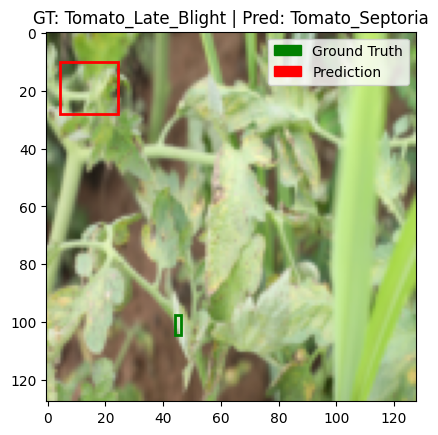

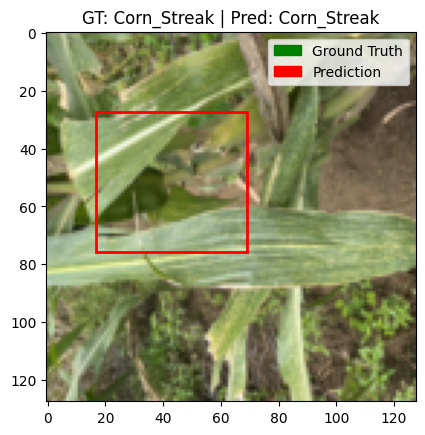

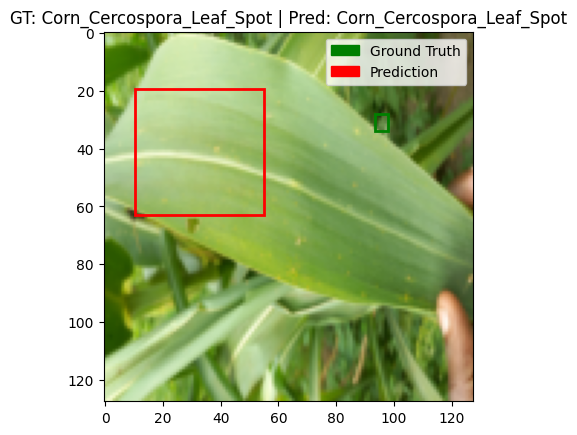

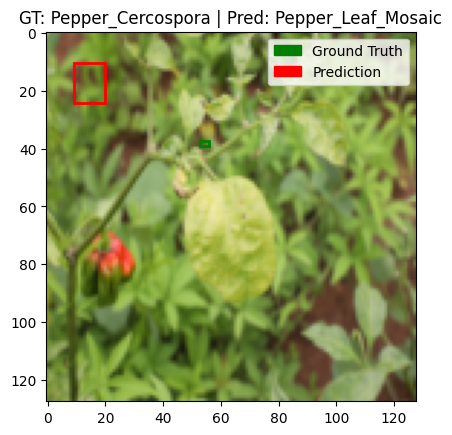

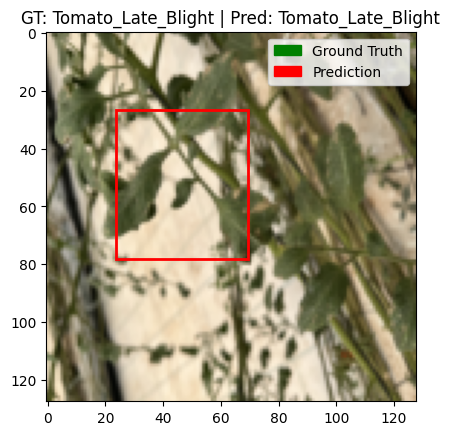

In [24]:
# import pandas as pd
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from tqdm import tqdm
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import torchvision.transforms as transforms
# import torchvision.models as models
# from torch.cuda.amp import GradScaler, autocast

# # -----------------------------
# # 1. Dataset Definition
# # -----------------------------

# class CachedDataset(Dataset):
#     def __init__(self, dataframe, cached_dir, original_image_size=(2560, 1440), resized_image_size=(128, 128)):
#         """
#         Args:
#             dataframe (pd.DataFrame): DataFrame containing image IDs, bbox coordinates, and class labels.
#             cached_dir (str): Directory where cached image tensors are stored.
#             original_image_size (tuple): Original image size as (width, height).
#             resized_image_size (tuple): Desired image size as (width, height).
#         """
#         self.dataframe = dataframe
#         self.cached_dir = cached_dir
#         self.original_width, self.original_height = original_image_size
#         self.resized_width, self.resized_height = resized_image_size
#         self.transform = transforms.Compose([
#             transforms.Resize(resized_image_size),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],  
#                                  std=[0.229, 0.224, 0.225])   
#         ])

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         image_id = self.dataframe.iloc[idx]['Image_ID']
#         cached_path = os.path.join(self.cached_dir, f"{image_id}.pt")
#         try:
#             image = torch.load(cached_path)
#         except Exception as e:
#             print(f"Error loading cached image {cached_path}: {e}")
#             # Return dummy data or handle appropriately
#             image = torch.zeros(3, self.resized_height, self.resized_width)  # Adjust size accordingly
#             bbox = torch.zeros(4, dtype=torch.float32)
#             label = torch.tensor(0, dtype=torch.long)
#             return image, {'boxes': bbox, 'labels': label}
        
#         # Extract bounding box coordinates and scale them
#         # Assuming original bbox coordinates are based on original_image_size
#         bbox_original = [
#             self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']
#         ]
#         # Scale bbox coordinates to match resized images
#         scale_x = self.resized_width / self.original_width
#         scale_y = self.resized_height / self.original_height
#         bbox_scaled = [
#             bbox_original[0] * scale_x,
#             bbox_original[1] * scale_y,
#             bbox_original[2] * scale_x,
#             bbox_original[3] * scale_y
#         ]
#         # Clamp bbox coordinates to image boundaries
#         bbox_scaled = [
#             min(max(bbox_scaled[0], 0), self.resized_width),
#             min(max(bbox_scaled[1], 0), self.resized_height),
#             min(max(bbox_scaled[2], 0), self.resized_width),
#             min(max(bbox_scaled[3], 0), self.resized_height)
#         ]
#         bbox = torch.tensor(bbox_scaled, dtype=torch.float32)
        
#         # Extract class label
#         label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
#         # Debugging: Print fetched item details
#         if idx < 10:  # Limit to first 10 to avoid excessive logging
#             print(f"Fetched index {idx}: Image_ID={image_id}, BBox={bbox}, Label={label}")
        
#         return image, {'boxes': bbox, 'labels': label}

# # -----------------------------
# # 2. Model Definition
# # -----------------------------

# class CustomCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomCNN, self).__init__()
#         # Use a pretrained ResNet18 backbone with updated weights parameter
#         self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
#         num_features = self.backbone.fc.in_features
#         self.backbone.fc = nn.Identity()  # Remove the original FC layer
        
#         # Define custom heads
#         self.dropout = nn.Dropout(0.5)
#         self.fc_bbox = nn.Linear(num_features, 4)
#         self.fc_class = nn.Linear(num_features, num_classes)
    
#     def forward(self, x):
#         features = self.backbone(x)
#         features = self.dropout(features)
#         bbox_output = self.fc_bbox(features)
#         class_output = self.fc_class(features)
#         return bbox_output, class_output

# # -----------------------------
# # 3. Helper Functions
# # -----------------------------

# def cache_images(dataframe, images_dir, cached_dir, transform):
#     """
#     Preprocess and cache images by applying transformations and saving as tensors.
    
#     Args:
#         dataframe (pd.DataFrame): DataFrame containing image information.
#         images_dir (str): Directory where original images are stored.
#         cached_dir (str): Directory to save cached image tensors.
#         transform (torchvision.transforms.Compose): Transformations to apply to images.
#     """
#     print("Caching images...")
#     for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
#         image_id = row['Image_ID']
#         image_path = os.path.join(images_dir, image_id)
#         cached_path = os.path.join(cached_dir, f"{image_id}.pt")
#         if not os.path.exists(cached_path):
#             try:
#                 image = Image.open(image_path).convert("RGB")
#                 image = transform(image)
#                 torch.save(image, cached_path)
#             except Exception as e:
#                 print(f"Error caching image {image_id}: {e}")

# def calculate_iou(box1, box2):
#     """
#     Calculate Intersection over Union (IoU) between two bounding boxes.
    
#     Args:
#         box1 (array-like): [xmin, ymin, xmax, ymax] for the first box.
#         box2 (array-like): [xmin, ymin, xmax, ymax] for the second box.
    
#     Returns:
#         float: IoU value.
#     """
#     x_left = max(box1[0], box2[0])
#     y_top    = max(box1[1], box2[1])
#     x_right  = min(box1[2], box2[2])
#     y_bottom = min(box1[3], box2[3])

#     if x_right < x_left or y_bottom < y_top:
#         return 0.0  # No overlap

#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
#     box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
#     iou = intersection_area / float(box1_area + box2_area - intersection_area)
#     return iou

# def evaluate_classification(model, dataloader, device):
#     """
#     Evaluate classification performance on the validation set.
    
#     Args:
#         model (nn.Module): Trained model.
#         dataloader (DataLoader): Validation DataLoader.
#         device (torch.device): Device to perform computations on.
#     """
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
#             if images is None or targets is None:
#                 continue

#             images = images.to(device, non_blocking=True)
#             labels = targets['labels'].to(device, non_blocking=True)

#             with autocast():
#                 _, preds = model(images)
#                 preds = torch.argmax(preds, dim=1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     accuracy = accuracy_score(all_labels, all_preds)
#     precision, recall, f1, _ = precision_recall_fscore_support(
#         all_labels, all_preds, average='weighted', zero_division=0
#     )
#     conf_matrix = confusion_matrix(all_labels, all_preds)

#     print("\n--- Classification Evaluation ---")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision (Weighted): {precision:.4f}")
#     print(f"Recall (Weighted): {recall:.4f}")
#     print(f"F1-Score (Weighted): {f1:.4f}")
#     print("Confusion Matrix:")
#     print(conf_matrix)

# def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
#     """
#     Evaluate bounding box predictions on the validation set.
    
#     Args:
#         model (nn.Module): Trained model.
#         dataloader (DataLoader): Validation DataLoader.
#         device (torch.device): Device to perform computations on.
#         iou_threshold (float): Threshold to consider a prediction as correct.
#     """
#     model.eval()
#     all_iou = []
#     matched = 0
#     total = 0

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
#             if images is None or targets is None:
#                 continue

#             images = images.to(device, non_blocking=True)
#             true_bboxes = targets['boxes'].to(device, non_blocking=True)

#             with autocast():
#                 pred_bboxes, _ = model(images)

#             pred_bboxes = pred_bboxes.cpu().numpy()
#             true_bboxes = true_bboxes.cpu().numpy()

#             for pred_box, true_box in zip(pred_bboxes, true_bboxes):
#                 iou = calculate_iou(pred_box, true_box)
#                 all_iou.append(iou)
#                 if iou >= iou_threshold:
#                     matched += 1
#                 total += 1

#     mean_iou = np.mean(all_iou) if all_iou else 0
#     precision_at_iou = matched / total if total > 0 else 0

#     print("\n--- Bounding Box Evaluation ---")
#     print(f"Mean IoU: {mean_iou:.4f}")
#     print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

# def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
#     """
#     Visualize model predictions on a subset of the validation set.
    
#     Args:
#         model (nn.Module): Trained model.
#         dataloader (DataLoader): Validation DataLoader.
#         device (torch.device): Device to perform computations on.
#         label_encoder (LabelEncoder): Label encoder to decode class labels.
#         num_samples (int): Number of samples to visualize.
#     """
#     model.eval()
#     samples_visualized = 0

#     with torch.no_grad():
#         for images, targets in dataloader:
#             if images is None or targets is None:
#                 continue

#             images = images.to(device, non_blocking=True)
#             true_bboxes = targets['boxes'].to(device, non_blocking=True)
#             true_labels = targets['labels'].to(device, non_blocking=True)

#             with autocast():
#                 pred_bboxes, pred_labels = model(images)
#                 preds = torch.argmax(pred_labels, dim=1)

#             images = images.cpu().numpy()
#             true_bboxes = true_bboxes.cpu().numpy()
#             preds = preds.cpu().numpy()
#             pred_bboxes = pred_bboxes.cpu().numpy()

#             for img, true_box, true_label, pred_box, pred_label in zip(
#                 images, true_bboxes, true_labels, pred_bboxes, preds
#             ):
#                 if samples_visualized >= num_samples:
#                     return

#                 fig, ax = plt.subplots(1)
#                 img = np.transpose(img, (1, 2, 0))  
#                 img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
#                 img = np.clip(img, 0, 1)
#                 ax.imshow(img)

#                 # Ground Truth Bounding Box
#                 gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
#                 gt_width = gt_xmax - gt_xmin
#                 gt_height = gt_ymax - gt_ymin
#                 gt_rect = patches.Rectangle(
#                     (gt_xmin, gt_ymin), gt_width, gt_height, 
#                     linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
#                 )
#                 ax.add_patch(gt_rect)

#                 # Predicted Bounding Box
#                 pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
#                 pred_width = pred_xmax - pred_xmin
#                 pred_height = pred_ymax - pred_ymin
#                 pred_rect = patches.Rectangle(
#                     (pred_xmin, pred_ymin), pred_width, pred_height, 
#                     linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
#                 )
#                 ax.add_patch(pred_rect)

#                 # Add Labels
#                 gt_class = label_encoder.inverse_transform([true_label])[0]
#                 pred_class = label_encoder.inverse_transform([pred_label])[0]
#                 plt.title(f"GT: {gt_class} | Pred: {pred_class}")

#                 # Create Legend
#                 handles = [
#                     patches.Patch(color='g', label='Ground Truth'),
#                     patches.Patch(color='r', label='Prediction')
#                 ]
#                 plt.legend(handles=handles)

#                 plt.show()

#                 samples_visualized += 1

# def validate_dataset(dataset, num_samples=10):
#     """
#     Validate the dataset by fetching and printing sample data.
    
#     Args:
#         dataset (Dataset): PyTorch Dataset to validate.
#         num_samples (int): Number of samples to validate.
#     """
#     print(f"Validating the first {num_samples} samples of the dataset...")
#     for i in range(min(num_samples, len(dataset))):
#         try:
#             image, targets = dataset[i]
#             print(f"Sample {i + 1}:")
#             print(f"  Image shape: {image.shape}")
#             print(f"  BBox: {targets['boxes']}")
#             print(f"  Label: {targets['labels']}")
#         except Exception as e:
#             print(f"Error in sample {i + 1}: {e}")

# # -----------------------------
# # 4. Main Function
# # -----------------------------

# def main():
#     # -----------------------------
#     # 1. Setup and Configuration
#     # -----------------------------

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     train_csv_path = 'Train.csv'  
#     images_dir = 'datasets/dataset/images/compressed/train'  
#     cached_dir = 'cached_images'  # Directory to store cached tensors
#     os.makedirs(cached_dir, exist_ok=True)

#     # -----------------------------
#     # 2. Data Preparation
#     # -----------------------------

#     # Load train data
#     train = pd.read_csv(train_csv_path)

#     # Encode class labels into numerical format using LabelEncoder
#     label_encoder = LabelEncoder()
#     train['class'] = label_encoder.fit_transform(train['class'])

#     # Check for missing or corrupted images
#     missing_images = []
#     for img_id in train['Image_ID']:
#         image_path = os.path.join(images_dir, img_id)
#         if not os.path.exists(image_path):
#             missing_images.append(img_id)
#         else:
#             try:
#                 img = Image.open(image_path)
#                 img.verify()  # Verify that it's an image
#             except Exception:
#                 missing_images.append(img_id)

#     if missing_images:
#         print(f"Found {len(missing_images)} missing or corrupted images. Removing them from the dataset.")
#         train = train[~train['Image_ID'].isin(missing_images)].reset_index(drop=True)
#     else:
#         print("All images are present and valid.")

#     print(f"Number of training samples after filtering: {len(train)}")

#     # Split data into training and validation sets (80% train, 20% val)
#     train_df, val_df = train_test_split(
#         train, 
#         test_size=0.2, 
#         random_state=42, 
#         stratify=train['class']
#     )

#     print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

#     # -----------------------------
#     # 3. Dataset and DataLoader
#     # -----------------------------

#     # Preprocess and cache images
#     cache_images(train_df, images_dir, cached_dir, transform=transforms.Compose([
#         transforms.Resize((128, 128)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],  
#                              std=[0.229, 0.224, 0.225])   
#     ]))
#     cache_images(val_df, images_dir, cached_dir, transform=transforms.Compose([
#         transforms.Resize((128, 128)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],  
#                              std=[0.229, 0.224, 0.225])   
#     ]))

#     # Define original image size
#     original_image_size = (2560, 1440)  # Replace with your actual image size
#     resized_image_size = (128, 128)

#     # Instantiate Cached Datasets
#     train_dataset = CachedDataset(dataframe=train_df, cached_dir=cached_dir, 
#                                   original_image_size=original_image_size, 
#                                   resized_image_size=resized_image_size)
#     val_dataset = CachedDataset(dataframe=val_df, cached_dir=cached_dir, 
#                                 original_image_size=original_image_size, 
#                                 resized_image_size=resized_image_size)

#     # Validate Datasets
#     validate_dataset(train_dataset)
#     validate_dataset(val_dataset)

#     # Determine optimal number of workers
#     num_workers = 0  # Set to 0 for initial debugging
#     print(f"Using {num_workers} workers for DataLoader.")

#     # Determine prefetch_factor based on num_workers
#     prefetch_factor = 2 if num_workers > 0 else None

#     # Instantiate DataLoaders with conditional prefetch_factor
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=128,          
#         shuffle=True,           
#         num_workers=num_workers,  
#         pin_memory=False,
#         persistent_workers=False,
#         prefetch_factor=prefetch_factor
#     )

#     val_loader = DataLoader(
#         val_dataset, 
#         batch_size=128,          
#         shuffle=False,          
#         num_workers=num_workers,  
#         pin_memory=False,
#         persistent_workers=False,
#         prefetch_factor=prefetch_factor
#     )

#     # -----------------------------
#     # 4. Model Definition
#     # -----------------------------

#     num_classes = len(train['class'].unique())

#     model = CustomCNN(num_classes=num_classes).to(device)

#     # Print the model structure (optional)
#     print(f"Custom CNN Model:\n{model}")

#     # -----------------------------
#     # 5. Training Loop with Optimizations
#     # -----------------------------

#     # Define loss functions
#     class IoULoss(nn.Module):
#         def __init__(self):
#             super(IoULoss, self).__init__()

#         def forward(self, pred_boxes, target_boxes):
#             # Remove sigmoid if bounding boxes are scaled to image dimensions
#             # pred_boxes = torch.sigmoid(pred_boxes)
#             # target_boxes = torch.sigmoid(target_boxes)
            
#             # Calculate Intersection coordinates
#             x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
#             y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
#             x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
#             y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])
            
#             # Calculate Intersection area
#             intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
            
#             # Calculate areas
#             pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]).clamp(min=0) * \
#                         (pred_boxes[:, 3] - pred_boxes[:, 1]).clamp(min=0)
#             target_area = (target_boxes[:, 2] - target_boxes[:, 0]).clamp(min=0) * \
#                           (target_boxes[:, 3] - target_boxes[:, 1]).clamp(min=0)
            
#             # Calculate Union area
#             union = pred_area + target_area - intersection + 1e-6  # Avoid division by zero
            
#             # Calculate IoU
#             iou = intersection / union
            
#             # Calculate IoU Loss
#             loss = 1 - iou
#             return loss.mean()

#     iou_loss_fn = IoULoss()
#     class_loss_fn = nn.CrossEntropyLoss()

#     # Define optimizer and scheduler
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#     # Initialize GradScaler for mixed precision
#     scaler = GradScaler()

#     # Define number of epochs
#     num_epochs = 10  # Adjust as needed

#     # Training loop with validation and checkpointing
#     for epoch in range(num_epochs):
#         print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
#         model.train()
#         total_iou_loss, total_class_loss = 0.0, 0.0
#         train_loader_iter = tqdm(train_loader, desc="Training", leave=False)

#         for batch_idx, (images, targets) in enumerate(train_loader_iter):
#             if images is None or targets is None:
#                 print(f"Skipping batch {batch_idx + 1} due to None values.")
#                 continue

#             # Debug statement to trace batch processing
#             # print(f"Processing batch {batch_idx + 1}/{len(train_loader)}")

#             images = images.to(device, non_blocking=True)
#             bboxes = targets['boxes'].to(device, non_blocking=True)
#             labels = targets['labels'].to(device, non_blocking=True)

#             optimizer.zero_grad()
            
#             with autocast():
#                 pred_bboxes, pred_labels = model(images)
#                 bbox_loss = iou_loss_fn(pred_bboxes, bboxes)
#                 class_loss = class_loss_fn(pred_labels, labels)
#                 total_loss = bbox_loss + class_loss
            
#             scaler.scale(total_loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             total_iou_loss += bbox_loss.item()
#             total_class_loss += class_loss.item()

#             # Log every 10 batches
#             if (batch_idx + 1) % 10 == 0:
#                 print(f"Batch {batch_idx + 1}/{len(train_loader)} - IoU Loss: {bbox_loss.item():.4f}, Class Loss: {class_loss.item():.4f}")

#             train_loader_iter.set_postfix({'IoU Loss': bbox_loss.item(), 'Class Loss': class_loss.item()})

#         avg_iou_loss = total_iou_loss / len(train_loader)
#         avg_class_loss = total_class_loss / len(train_loader)
#         print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

#         scheduler.step()

#         # -----------------------------
#         # 6. Validation After Each Epoch
#         # -----------------------------

#         print(f"\n=== Validation After Epoch {epoch + 1} ===")
#         evaluate_classification(model, val_loader, device)
#         evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

#         # -----------------------------
#         # 7. Save the Trained Model
#         # -----------------------------

#         checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
#         torch.save(model.state_dict(), checkpoint_path)
#         print(f"Checkpoint saved to '{checkpoint_path}'")

#     # -----------------------------
#     # 8. Visualization of Predictions (Optional)
#     # -----------------------------

#     print("\n=== Visualizing Predictions on Validation Set ===")
#     visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)

# # -----------------------------
# # 5. Entry Point
# # -----------------------------

# if __name__ == "__main__":
#     main()

import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torchvision.models as models
from torch.cuda.amp import GradScaler, autocast

# -----------------------------
# 1. Dataset Definition
# -----------------------------

class CachedDataset(Dataset):
    def __init__(self, dataframe, cached_dir, original_image_size=(2560, 1440), resized_image_size=(128, 128)):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image IDs, bbox coordinates, and class labels.
            cached_dir (str): Directory where cached image tensors are stored.
            original_image_size (tuple): Original image size as (width, height).
            resized_image_size (tuple): Desired image size as (width, height).
        """
        self.dataframe = dataframe
        self.cached_dir = cached_dir
        self.original_width, self.original_height = original_image_size
        self.resized_width, self.resized_height = resized_image_size
        self.transform = transforms.Compose([
            transforms.Resize(resized_image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                                 std=[0.229, 0.224, 0.225])   
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['Image_ID']
        cached_path = os.path.join(self.cached_dir, f"{image_id}.pt")
        try:
            image = torch.load(cached_path)
        except Exception as e:
            print(f"Error loading cached image {cached_path}: {e}")
            # Return dummy data or handle appropriately
            image = torch.zeros(3, self.resized_height, self.resized_width)  # Adjust size accordingly
            bbox = torch.zeros(4, dtype=torch.float32)
            label = torch.tensor(0, dtype=torch.long)
            return image, {'boxes': bbox, 'labels': label}
        
        # Extract bounding box coordinates and scale them
        # Assuming original bbox coordinates are based on original_image_size
        bbox_original = [
            self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']
        ]
        # Scale bbox coordinates to match resized images
        scale_x = self.resized_width / self.original_width
        scale_y = self.resized_height / self.original_height
        bbox_scaled = [
            bbox_original[0] * scale_x,
            bbox_original[1] * scale_y,
            bbox_original[2] * scale_x,
            bbox_original[3] * scale_y
        ]
        # Clamp bbox coordinates to image boundaries
        bbox_scaled = [
            min(max(bbox_scaled[0], 0), self.resized_width),
            min(max(bbox_scaled[1], 0), self.resized_height),
            min(max(bbox_scaled[2], 0), self.resized_width),
            min(max(bbox_scaled[3], 0), self.resized_height)
        ]
        bbox = torch.tensor(bbox_scaled, dtype=torch.float32)
        
        # Extract class label
        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
        # Debugging: Print fetched item details for the first few samples
        if idx < 10:  # Limit to first 10 to avoid excessive logging
            print(f"Fetched index {idx}: Image_ID={image_id}, BBox={bbox}, Label={label}")
        
        return image, {'boxes': bbox, 'labels': label}

# -----------------------------
# 2. Model Definition
# -----------------------------

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Use a pretrained ResNet18 backbone with updated weights parameter
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove the original FC layer
        
        # Define custom heads
        self.dropout = nn.Dropout(0.5)
        self.fc_bbox = nn.Linear(num_features, 4)
        self.fc_class = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)
        bbox_output = self.fc_bbox(features)
        class_output = self.fc_class(features)
        return bbox_output, class_output

# -----------------------------
# 3. Helper Functions
# -----------------------------

def cache_images(dataframe, images_dir, cached_dir, transform):
    """
    Preprocess and cache images by applying transformations and saving as tensors.
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing image information.
        images_dir (str): Directory where original images are stored.
        cached_dir (str): Directory to save cached image tensors.
        transform (torchvision.transforms.Compose): Transformations to apply to images.
    """
    print("Caching images...")
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Caching Images"):
        image_id = row['Image_ID']
        image_path = os.path.join(images_dir, image_id)
        cached_path = os.path.join(cached_dir, f"{image_id}.pt")
        if not os.path.exists(cached_path):
            try:
                image = Image.open(image_path).convert("RGB")
                image = transform(image)
                torch.save(image, cached_path)
            except Exception as e:
                print(f"Error caching image {image_id}: {e}")

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1 (array-like): [xmin, ymin, xmax, ymax] for the first box.
        box2 (array-like): [xmin, ymin, xmax, ymax] for the second box.
    
    Returns:
        float: IoU value.
    """
    x_left = max(box1[0], box2[0])
    y_top    = max(box1[1], box2[1])
    x_right  = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

def evaluate_classification(model, dataloader, device):
    """
    Evaluate classification performance on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
    
    Returns:
        float: Validation accuracy.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                _, preds = model(images)
                preds = torch.argmax(preds, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n--- Classification Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy  # Return accuracy for scheduler and checkpointing

def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
    """
    Evaluate bounding box predictions on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        iou_threshold (float): Threshold to consider a prediction as correct.
    """
    model.eval()
    all_iou = []
    matched = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, _ = model(images)

            pred_bboxes = pred_bboxes.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()

            for pred_box, true_box in zip(pred_bboxes, true_bboxes):
                iou = calculate_iou(pred_box, true_box)
                all_iou.append(iou)
                if iou >= iou_threshold:
                    matched += 1
                total += 1

    mean_iou = np.mean(all_iou) if all_iou else 0
    precision_at_iou = matched / total if total > 0 else 0

    print("\n--- Bounding Box Evaluation ---")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
    """
    Visualize model predictions on a subset of the validation set.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        label_encoder (LabelEncoder): Label encoder to decode class labels.
        num_samples (int): Number of samples to visualize.
    """
    model.eval()
    samples_visualized = 0

    with torch.no_grad():
        for images, targets in dataloader:
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)
            true_labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, pred_labels = model(images)
                preds = torch.argmax(pred_labels, dim=1)

            images = images.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()
            preds = preds.cpu().numpy()
            pred_bboxes = pred_bboxes.cpu().numpy()

            for img, true_box, true_label, pred_box, pred_label in zip(
                images, true_bboxes, true_labels, pred_bboxes, preds
            ):
                if samples_visualized >= num_samples:
                    return

                fig, ax = plt.subplots(1)
                img = np.transpose(img, (1, 2, 0))  
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                # Ground Truth Bounding Box
                gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
                gt_width = gt_xmax - gt_xmin
                gt_height = gt_ymax - gt_ymin
                gt_rect = patches.Rectangle(
                    (gt_xmin, gt_ymin), gt_width, gt_height, 
                    linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(gt_rect)

                # Predicted Bounding Box
                pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
                pred_width = pred_xmax - pred_xmin
                pred_height = pred_ymax - pred_ymin
                pred_rect = patches.Rectangle(
                    (pred_xmin, pred_ymin), pred_width, pred_height, 
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(pred_rect)

                # Add Labels
                gt_class = label_encoder.inverse_transform([true_label.item()])[0]
                pred_class = label_encoder.inverse_transform([pred_label.item()])[0]
                plt.title(f"GT: {gt_class} | Pred: {pred_class}")

                # Create Legend
                handles = [
                    patches.Patch(color='g', label='Ground Truth'),
                    patches.Patch(color='r', label='Prediction')
                ]
                plt.legend(handles=handles)

                plt.show()

                samples_visualized += 1


def validate_dataset(dataset, num_samples=10):
    """
    Validate the dataset by fetching and printing sample data.
    
    Args:
        dataset (Dataset): PyTorch Dataset to validate.
        num_samples (int): Number of samples to validate.
    """
    print(f"Validating the first {num_samples} samples of the dataset...")
    for i in range(min(num_samples, len(dataset))):
        try:
            image, targets = dataset[i]
            print(f"Sample {i + 1}:")
            print(f"  Image shape: {image.shape}")
            print(f"  BBox: {targets['boxes']}")
            print(f"  Label: {targets['labels']}")
        except Exception as e:
            print(f"Error in sample {i + 1}: {e}")

# -----------------------------
# 4. Main Function
# -----------------------------

def main():
    # -----------------------------
    # 1. Setup and Configuration
    # -----------------------------

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_csv_path = 'Train.csv'  
    images_dir = 'datasets/dataset/images/train'  
    cached_dir = 'cached_images'  # Directory to store cached tensors
    os.makedirs(cached_dir, exist_ok=True)

    # -----------------------------
    # 2. Data Preparation
    # -----------------------------

    # Load train data
    train = pd.read_csv(train_csv_path)

    # Encode class labels into numerical format using LabelEncoder
    label_encoder = LabelEncoder()
    train['class'] = label_encoder.fit_transform(train['class'])

    # Check for missing or corrupted images
    missing_images = []
    for img_id in train['Image_ID']:
        image_path = os.path.join(images_dir, img_id)
        if not os.path.exists(image_path):
            missing_images.append(img_id)
        else:
            try:
                img = Image.open(image_path)
                img.verify()  # Verify that it's an image
            except Exception:
                missing_images.append(img_id)

    if missing_images:
        print(f"Found {len(missing_images)} missing or corrupted images. Removing them from the dataset.")
        train = train[~train['Image_ID'].isin(missing_images)].reset_index(drop=True)
    else:
        print("All images are present and valid.")

    print(f"Number of training samples after filtering: {len(train)}")

    # Split data into training and validation sets (80% train, 20% val)
    train_df, val_df = train_test_split(
        train, 
        test_size=0.2, 
        random_state=42, 
        stratify=train['class']
    )

    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    # -----------------------------
    # 3. Dataset and DataLoader
    # -----------------------------

    # Preprocess and cache images
    cache_images(train_df, images_dir, cached_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ]))
    cache_images(val_df, images_dir, cached_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ]))

    # Define original image size
    original_image_size = (2560, 1440)  # Replace with your actual image size
    resized_image_size = (128, 128)

    # Instantiate Cached Datasets
    train_dataset = CachedDataset(dataframe=train_df, cached_dir=cached_dir, 
                                  original_image_size=original_image_size, 
                                  resized_image_size=resized_image_size)
    val_dataset = CachedDataset(dataframe=val_df, cached_dir=cached_dir, 
                                original_image_size=original_image_size, 
                                resized_image_size=resized_image_size)

    # Validate Datasets
    validate_dataset(train_dataset)
    validate_dataset(val_dataset)

    # Determine optimal number of workers
    num_workers = 0  # Set to 0 for initial debugging; increase based on system
    print(f"Using {num_workers} workers for DataLoader.")

    # Determine prefetch_factor based on num_workers
    prefetch_factor = 2 if num_workers > 0 else None

    # Instantiate DataLoaders with conditional prefetch_factor
    train_loader = DataLoader(
        train_dataset, 
        batch_size=128,          
        shuffle=True,           
        num_workers=num_workers,  
        pin_memory=False,
        persistent_workers=False,
        prefetch_factor=prefetch_factor
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=128,          
        shuffle=False,          
        num_workers=num_workers,  
        pin_memory=False,
        persistent_workers=False,
        prefetch_factor=prefetch_factor
    )

    # -----------------------------
    # 4. Model Definition
    # -----------------------------

    num_classes = len(train['class'].unique())

    model = CustomCNN(num_classes=num_classes).to(device)

    # Print the model structure (optional)
    print(f"Custom CNN Model:\n{model}")

    # -----------------------------
    # 5. Training Loop with Optimizations
    # -----------------------------

    # Define loss functions
    class IoULoss(nn.Module):
        def __init__(self):
            super(IoULoss, self).__init__()

        def forward(self, pred_boxes, target_boxes):
            # Calculate Intersection coordinates
            x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
            y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
            x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
            y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])
            
            # Calculate Intersection area
            intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
            
            # Calculate areas
            pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]).clamp(min=0) * \
                        (pred_boxes[:, 3] - pred_boxes[:, 1]).clamp(min=0)
            target_area = (target_boxes[:, 2] - target_boxes[:, 0]).clamp(min=0) * \
                          (target_boxes[:, 3] - target_boxes[:, 1]).clamp(min=0)
            
            # Calculate Union area
            union = pred_area + target_area - intersection + 1e-6  # Avoid division by zero
            
            # Calculate IoU
            iou = intersection / union
            
            # Calculate IoU Loss
            loss = 1 - iou
            return loss.mean()

    iou_loss_fn = IoULoss()
    class_loss_fn = nn.CrossEntropyLoss()

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    # Define number of epochs
    num_epochs = 3  # Adjust as needed

    # Training loop with validation and checkpointing
    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
        model.train()
        total_iou_loss, total_class_loss = 0.0, 0.0
        train_loader_iter = tqdm(train_loader, desc="Training", leave=False)

        for batch_idx, (images, targets) in enumerate(train_loader_iter):
            if images is None or targets is None:
                print(f"Skipping batch {batch_idx + 1} due to None values.")
                continue

            images = images.to(device, non_blocking=True)
            bboxes = targets['boxes'].to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            optimizer.zero_grad()
            
            with autocast():
                pred_bboxes, pred_labels = model(images)
                bbox_loss = iou_loss_fn(pred_bboxes, bboxes)
                class_loss = class_loss_fn(pred_labels, labels)
                total_loss = bbox_loss + class_loss
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_iou_loss += bbox_loss.item()
            total_class_loss += class_loss.item()

            # Update tqdm progress bar with current batch loss
            train_loader_iter.set_postfix({'IoU Loss': f"{bbox_loss.item():.4f}", 
                                          'Class Loss': f"{class_loss.item():.4f}"})

        avg_iou_loss = total_iou_loss / len(train_loader)
        avg_class_loss = total_class_loss / len(train_loader)
        print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

        scheduler.step()

        # -----------------------------
        # 6. Validation After Each Epoch
        # -----------------------------

        print(f"\n=== Validation After Epoch {epoch + 1} ===")
        val_accuracy = evaluate_classification(model, val_loader, device)
        evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

        # -----------------------------
        # 7. Save the Trained Model
        # -----------------------------

        checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to '{checkpoint_path}'")

    # -----------------------------
    # 8. Visualization of Predictions (Optional)
    # -----------------------------

    print("\n=== Visualizing Predictions on Validation Set ===")
    visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)

# -----------------------------
# 5. Entry Point
# -----------------------------

if __name__ == "__main__":
    main()



Using device: cuda


Checking images: 100%|██████████| 41029/41029 [00:03<00:00, 11044.27it/s]


Found 10252 missing or corrupted images. Removing them from the dataset.
Number of training samples after filtering: 30777
Training samples: 24621, Validation samples: 6156
Removed 24550 samples with invalid bounding boxes.
Removed 6140 samples with invalid bounding boxes.
Training samples after filtering: 71, Validation samples after filtering: 16
Caching images...


Caching Images: 100%|██████████| 71/71 [00:00<00:00, 11821.51it/s]


Caching images...


Caching Images: 100%|██████████| 16/16 [00:00<00:00, 5336.26it/s]


All bounding boxes are valid.
All bounding boxes are valid.
Validating the first 10 samples of the dataset...
Fetched index 0: Image_ID=id_3lby1s.jpg, BBox=[6.440280914306641, 5.714285850524902, 109.8711929321289, 83.86416625976562], Label=22
Sample 1:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([  6.4403,   5.7143, 109.8712,  83.8642])
  Label: 22
Fetched index 1: Image_ID=id_ippbt3.jpg, BBox=[8.435562133789062, 12.608441352844238, 128.0, 128.0], Label=1
Sample 2:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([  8.4356,  12.6084, 128.0000, 128.0000])
  Label: 1
Fetched index 2: Image_ID=id_2beu1w.jpg, BBox=[30.93039321899414, 35.1015510559082, 128.0, 128.0], Label=2
Sample 3:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 30.9304,  35.1016, 128.0000, 128.0000])
  Label: 2
Fetched index 3: Image_ID=id_h8no6l.jpg, BBox=[62.34917449951172, 99.18712615966797, 128.0, 128.0], Label=22
Sample 4:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 62.349

Training:  33%|███▎      | 1/3 [00:00<00:00,  9.35it/s, IoU Loss=88.8140, Class Loss=4.6378]

Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3
Fetched index 8: Image_ID=id_5dhqfs.jpg, BBox=[25.306684494018555, 0.0, 128.0, 128.0], Label=2
Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3
Fetched index 4: Image_ID=id_2ls1zv.jpg, BBox=[2.649730920791626, 70.63067626953125, 128.0, 128.0], Label=14
Fetched index 0: Image_ID=id_3lby1s.jpg, BBox=[6.440280914306641, 5.714285850524902, 109.8711929321289, 83.86416625976562], Label=22
Fetched index 9: Image_ID=id_ym5hyb.jpg, BBox=[33.74224853515625, 68.84121704101562, 128.0, 128.0], Label=2
Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3
Fetched index 1: Image_ID=id_ippbt3.jpg, BBox=[8.435562133789062, 12.608441352844238, 128.0, 128.0], Label=1
Fetched index 6: Image_ID=id_plsmoh.jpg, BBox=[59.04893112182617, 43.53646469116211, 128.0, 128.0], Label=2
Fetched ind

Training Losses -> IoU Loss: 95.7211, Class Loss: 3.9433

=== Validation After Epoch 1 ===


Fetched index 0: Image_ID=id_dckw2d.jpg, BBox=[0.0, 4.173525810241699, 128.0, 128.0], Label=1
Fetched index 1: Image_ID=id_g9qffw.jpg, BBox=[0.03512880578637123, 39.3618278503418, 128.0, 128.0], Label=18
Fetched index 2: Image_ID=id_842sys.jpg, BBox=[120.90971374511719, 71.6528549194336, 128.0, 128.0], Label=0
Fetched index 3: Image_ID=id_i1jpbi.jpg, BBox=[119.3970718383789, 54.65944290161133, 128.0, 128.0], Label=18
Fetched index 4: Image_ID=id_pe4jll.jpg, BBox=[36.554100036621094, 43.53646469116211, 128.0, 128.0], Label=1
Fetched index 5: Image_ID=id_couafm.jpg, BBox=[97.17479705810547, 106.97662353515625, 128.0, 128.0], Label=18
Fetched index 6: Image_ID=id_9xz995.jpg, BBox=[44.33943176269531, 14.87804889678955, 128.0, 128.0], Label=18
Fetched index 7: Image_ID=id_y6mzzv.jpg, BBox=[36.554100036621094, 18.231718063354492, 128.0, 128.0], Label=1
Fetched index 8: Image_ID=id_gglqeb.jpg, BBox=[47.801517486572266, 122.26234436035156, 128.0, 128.0], Label=2
Fetched index 9: Image_ID=id_vo

Fetched index 0: Image_ID=id_dckw2d.jpg, BBox=[0.0, 4.173525810241699, 128.0, 128.0], Label=1
Fetched index 1: Image_ID=id_g9qffw.jpg, BBox=[0.03512880578637123, 39.3618278503418, 128.0, 128.0], Label=18
Fetched index 2: Image_ID=id_842sys.jpg, BBox=[120.90971374511719, 71.6528549194336, 128.0, 128.0], Label=0
Fetched index 3: Image_ID=id_i1jpbi.jpg, BBox=[119.3970718383789, 54.65944290161133, 128.0, 128.0], Label=18
Fetched index 4: Image_ID=id_pe4jll.jpg, BBox=[36.554100036621094, 43.53646469116211, 128.0, 128.0], Label=1
Fetched index 5: Image_ID=id_couafm.jpg, BBox=[97.17479705810547, 106.97662353515625, 128.0, 128.0], Label=18
Fetched index 6: Image_ID=id_9xz995.jpg, BBox=[44.33943176269531, 14.87804889678955, 128.0, 128.0], Label=18
Fetched index 7: Image_ID=id_y6mzzv.jpg, BBox=[36.554100036621094, 18.231718063354492, 128.0, 128.0], Label=1
Fetched index 8: Image_ID=id_gglqeb.jpg, BBox=[47.801517486572266, 122.26234436035156, 128.0, 128.0], Label=2
Fetched index 9: Image_ID=id_vo

Training:   0%|          | 0/3 [00:00<?, ?it/s, IoU Loss=93.9617, Class Loss=2.5221]

Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3
Fetched index 3: Image_ID=id_h8no6l.jpg, BBox=[62.34917449951172, 99.18712615966797, 128.0, 128.0], Label=22
Fetched index 6: Image_ID=id_plsmoh.jpg, BBox=[59.04893112182617, 43.53646469116211, 128.0, 128.0], Label=2
Fetched index 3: Image_ID=id_h8no6l.jpg, BBox=[62.34917449951172, 99.18712615966797, 128.0, 128.0], Label=22
Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3
Fetched index 4: Image_ID=id_2ls1zv.jpg, BBox=[2.649730920791626, 70.63067626953125, 128.0, 128.0], Label=14
Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3
Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3


Training:   0%|          | 0/3 [00:00<?, ?it/s, IoU Loss=102.1983, Class Loss=2.5464]

Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3


Training Losses -> IoU Loss: 96.3532, Class Loss: 2.3055

=== Validation After Epoch 2 ===


Fetched index 0: Image_ID=id_dckw2d.jpg, BBox=[0.0, 4.173525810241699, 128.0, 128.0], Label=1
Fetched index 1: Image_ID=id_g9qffw.jpg, BBox=[0.03512880578637123, 39.3618278503418, 128.0, 128.0], Label=18
Fetched index 2: Image_ID=id_842sys.jpg, BBox=[120.90971374511719, 71.6528549194336, 128.0, 128.0], Label=0
Fetched index 3: Image_ID=id_i1jpbi.jpg, BBox=[119.3970718383789, 54.65944290161133, 128.0, 128.0], Label=18
Fetched index 4: Image_ID=id_pe4jll.jpg, BBox=[36.554100036621094, 43.53646469116211, 128.0, 128.0], Label=1
Fetched index 5: Image_ID=id_couafm.jpg, BBox=[97.17479705810547, 106.97662353515625, 128.0, 128.0], Label=18
Fetched index 6: Image_ID=id_9xz995.jpg, BBox=[44.33943176269531, 14.87804889678955, 128.0, 128.0], Label=18
Fetched index 7: Image_ID=id_y6mzzv.jpg, BBox=[36.554100036621094, 18.231718063354492, 128.0, 128.0], Label=1
Fetched index 8: Image_ID=id_gglqeb.jpg, BBox=[47.801517486572266, 122.26234436035156, 128.0, 128.0], Label=2
Fetched index 9: Image_ID=id_vo

Fetched index 0: Image_ID=id_dckw2d.jpg, BBox=[0.0, 4.173525810241699, 128.0, 128.0], Label=1
Fetched index 1: Image_ID=id_g9qffw.jpg, BBox=[0.03512880578637123, 39.3618278503418, 128.0, 128.0], Label=18
Fetched index 2: Image_ID=id_842sys.jpg, BBox=[120.90971374511719, 71.6528549194336, 128.0, 128.0], Label=0
Fetched index 3: Image_ID=id_i1jpbi.jpg, BBox=[119.3970718383789, 54.65944290161133, 128.0, 128.0], Label=18
Fetched index 4: Image_ID=id_pe4jll.jpg, BBox=[36.554100036621094, 43.53646469116211, 128.0, 128.0], Label=1
Fetched index 5: Image_ID=id_couafm.jpg, BBox=[97.17479705810547, 106.97662353515625, 128.0, 128.0], Label=18
Fetched index 6: Image_ID=id_9xz995.jpg, BBox=[44.33943176269531, 14.87804889678955, 128.0, 128.0], Label=18
Fetched index 7: Image_ID=id_y6mzzv.jpg, BBox=[36.554100036621094, 18.231718063354492, 128.0, 128.0], Label=1
Fetched index 8: Image_ID=id_gglqeb.jpg, BBox=[47.801517486572266, 122.26234436035156, 128.0, 128.0], Label=2
Fetched index 9: Image_ID=id_vo

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3


Training:   0%|          | 0/3 [00:00<?, ?it/s, IoU Loss=94.5810, Class Loss=2.2274]

Fetched index 3: Image_ID=id_h8no6l.jpg, BBox=[62.34917449951172, 99.18712615966797, 128.0, 128.0], Label=22
Fetched index 4: Image_ID=id_2ls1zv.jpg, BBox=[2.649730920791626, 70.63067626953125, 128.0, 128.0], Label=14
Fetched index 3: Image_ID=id_h8no6l.jpg, BBox=[62.34917449951172, 99.18712615966797, 128.0, 128.0], Label=22
Fetched index 0: Image_ID=id_3lby1s.jpg, BBox=[6.440280914306641, 5.714285850524902, 109.8711929321289, 83.86416625976562], Label=22


Training:   0%|          | 0/3 [00:00<?, ?it/s, IoU Loss=96.0359, Class Loss=3.0152]

Fetched index 5: Image_ID=id_lq5bp6.jpg, BBox=[94.78936767578125, 105.81629180908203, 128.0, 128.0], Label=3


Training Losses -> IoU Loss: 95.1806, Class Loss: 2.2866

=== Validation After Epoch 3 ===


Fetched index 0: Image_ID=id_dckw2d.jpg, BBox=[0.0, 4.173525810241699, 128.0, 128.0], Label=1
Fetched index 1: Image_ID=id_g9qffw.jpg, BBox=[0.03512880578637123, 39.3618278503418, 128.0, 128.0], Label=18
Fetched index 2: Image_ID=id_842sys.jpg, BBox=[120.90971374511719, 71.6528549194336, 128.0, 128.0], Label=0
Fetched index 3: Image_ID=id_i1jpbi.jpg, BBox=[119.3970718383789, 54.65944290161133, 128.0, 128.0], Label=18
Fetched index 4: Image_ID=id_pe4jll.jpg, BBox=[36.554100036621094, 43.53646469116211, 128.0, 128.0], Label=1
Fetched index 5: Image_ID=id_couafm.jpg, BBox=[97.17479705810547, 106.97662353515625, 128.0, 128.0], Label=18
Fetched index 6: Image_ID=id_9xz995.jpg, BBox=[44.33943176269531, 14.87804889678955, 128.0, 128.0], Label=18
Fetched index 7: Image_ID=id_y6mzzv.jpg, BBox=[36.554100036621094, 18.231718063354492, 128.0, 128.0], Label=1
Fetched index 8: Image_ID=id_gglqeb.jpg, BBox=[47.801517486572266, 122.26234436035156, 128.0, 128.0], Label=2
Fetched index 9: Image_ID=id_vo

Fetched index 0: Image_ID=id_dckw2d.jpg, BBox=[0.0, 4.173525810241699, 128.0, 128.0], Label=1
Fetched index 1: Image_ID=id_g9qffw.jpg, BBox=[0.03512880578637123, 39.3618278503418, 128.0, 128.0], Label=18
Fetched index 2: Image_ID=id_842sys.jpg, BBox=[120.90971374511719, 71.6528549194336, 128.0, 128.0], Label=0
Fetched index 3: Image_ID=id_i1jpbi.jpg, BBox=[119.3970718383789, 54.65944290161133, 128.0, 128.0], Label=18
Fetched index 4: Image_ID=id_pe4jll.jpg, BBox=[36.554100036621094, 43.53646469116211, 128.0, 128.0], Label=1
Fetched index 5: Image_ID=id_couafm.jpg, BBox=[97.17479705810547, 106.97662353515625, 128.0, 128.0], Label=18
Fetched index 6: Image_ID=id_9xz995.jpg, BBox=[44.33943176269531, 14.87804889678955, 128.0, 128.0], Label=18
Fetched index 7: Image_ID=id_y6mzzv.jpg, BBox=[36.554100036621094, 18.231718063354492, 128.0, 128.0], Label=1
Fetched index 8: Image_ID=id_gglqeb.jpg, BBox=[47.801517486572266, 122.26234436035156, 128.0, 128.0], Label=2
Fetched index 9: Image_ID=id_vo

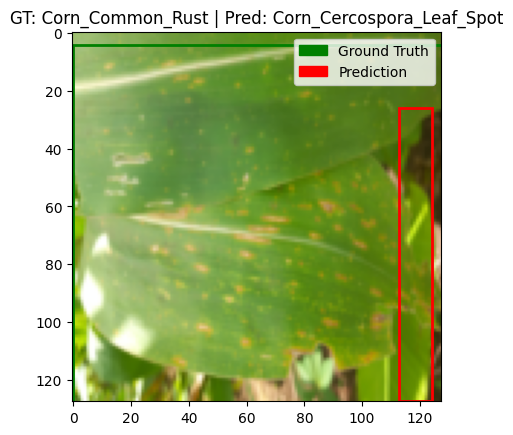

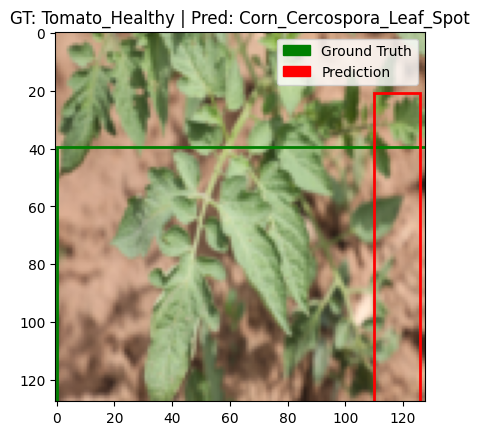

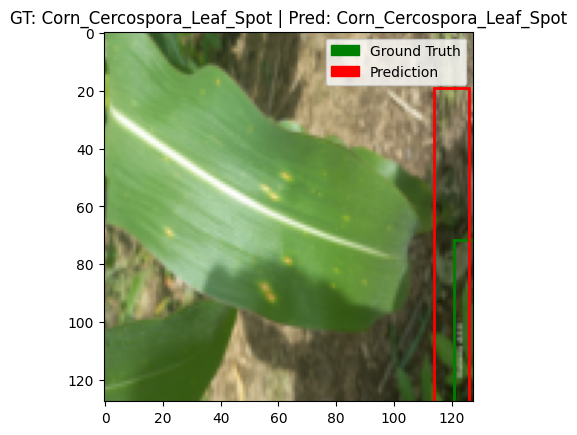

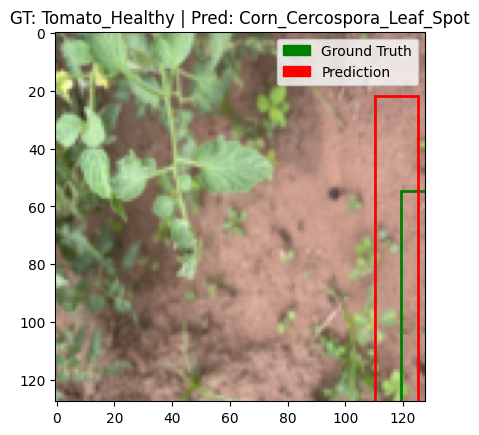

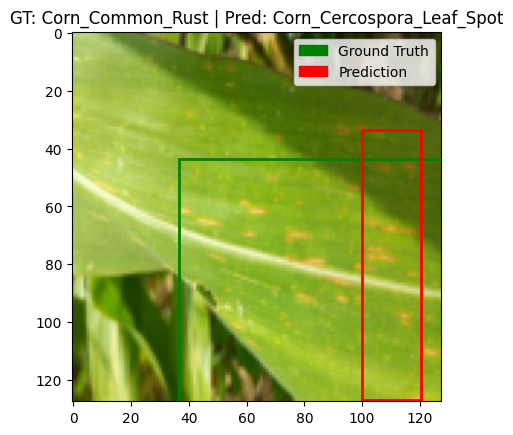

In [25]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torchvision.models as models
from torch.cuda.amp import GradScaler, autocast

# -----------------------------
# 1. Dataset Definition
# -----------------------------

class CachedDataset(Dataset):
    def __init__(self, dataframe, cached_dir, transform=None, resized_image_size=(128, 128)):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image IDs, bbox coordinates, and class labels.
            cached_dir (str): Directory where cached image tensors are stored.
            transform (torchvision.transforms.Compose, optional): Transformations to apply to images.
            resized_image_size (tuple): Desired image size as (width, height).
        """
        self.dataframe = dataframe.copy()
        self.cached_dir = cached_dir
        self.transform = transform
        self.resized_width, self.resized_height = resized_image_size
        self.normalize_bbox()
        self.filter_invalid_bboxes()

    def normalize_bbox(self):
        """Ensure bounding boxes are within [0, resized_dim]."""
        self.dataframe['xmin'] = self.dataframe['xmin'].clip(0, self.resized_width)
        self.dataframe['xmax'] = self.dataframe['xmax'].clip(0, self.resized_width)
        self.dataframe['ymin'] = self.dataframe['ymin'].clip(0, self.resized_height)
        self.dataframe['ymax'] = self.dataframe['ymax'].clip(0, self.resized_height)

    def filter_invalid_bboxes(self):
        """Remove samples with invalid bounding boxes (zero area)."""
        valid_indices = self.dataframe[
            (self.dataframe['xmin'] < self.dataframe['xmax']) &
            (self.dataframe['ymin'] < self.dataframe['ymax'])
        ].index
        num_invalid = len(self.dataframe) - len(valid_indices)
        if num_invalid > 0:
            print(f"Removed {num_invalid} samples with invalid bounding boxes.")
            self.dataframe = self.dataframe.loc[valid_indices].reset_index(drop=True)
        else:
            print("All bounding boxes are valid.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['Image_ID']
        cached_path = os.path.join(self.cached_dir, f"{image_id}.pt")
        try:
            image = torch.load(cached_path)
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            raise RuntimeError(f"Error loading cached image {cached_path}: {e}")
        
        # Extract bounding box coordinates and ensure they are within [0, resized_dim]
        try:
            bbox_original = [
                self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']
            ]
            bbox = torch.tensor(bbox_original, dtype=torch.float32)
        except Exception as e:
            raise RuntimeError(f"Error processing bounding boxes for image {image_id}: {e}")
        
        # Extract class label
        try:
            label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error processing label for image {image_id}: {e}")
        
        # Debugging: Print fetched item details for the first few samples
        if idx < 10:  # Limit to first 10 to avoid excessive logging
            print(f"Fetched index {idx}: Image_ID={image_id}, BBox={bbox.tolist()}, Label={label.item()}")
        
        return image, {'boxes': bbox, 'labels': label}

# -----------------------------
# 2. Model Definition
# -----------------------------

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Initialize ResNet18 from scratch (no pretrained weights)
        self.backbone = models.resnet18(weights=None)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove the original FC layer
        
        # Define custom heads
        self.dropout = nn.Dropout(0.5)
        self.fc_bbox = nn.Linear(num_features, 4)
        self.fc_class = nn.Linear(num_features, num_classes)
        self.sigmoid = nn.Sigmoid()  # Activation for bbox to constrain outputs
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Xavier Initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)
        bbox_output = self.sigmoid(self.fc_bbox(features))  # Ensure outputs are between 0 and 1
        class_output = self.fc_class(features)
        return bbox_output, class_output

# -----------------------------
# 3. Helper Functions
# -----------------------------

def cache_images(dataframe, images_dir, cached_dir, transform=None):
    """
    Preprocess and cache images by applying transformations and saving as tensors.
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing image information.
        images_dir (str): Directory where original images are stored.
        cached_dir (str): Directory to save cached image tensors.
        transform (torchvision.transforms.Compose, optional): Transformations to apply to images.
    """
    print("Caching images...")
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Caching Images"):
        image_id = row['Image_ID']
        image_path = os.path.join(images_dir, image_id)
        cached_path = os.path.join(cached_dir, f"{image_id}.pt")
        if not os.path.exists(cached_path):
            try:
                image = Image.open(image_path).convert("RGB")
                image = transform(image) if transform else transforms.ToTensor()(image)
                torch.save(image, cached_path)
            except Exception as e:
                print(f"Error caching image {image_id}: {e}")

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1 (array-like): [xmin, ymin, xmax, ymax] for the first box.
        box2 (array-like): [xmin, ymin, xmax, ymax] for the second box.
    
    Returns:
        float: IoU value.
    """
    x_left = max(box1[0], box2[0])
    y_top    = max(box1[1], box2[1])
    x_right  = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

def evaluate_classification(model, dataloader, device):
    """
    Evaluate classification performance on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
    
    Returns:
        float: Validation accuracy.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                _, preds = model(images)
                preds = torch.argmax(preds, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n--- Classification Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy  # Return accuracy for scheduler and checkpointing

def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
    """
    Evaluate bounding box predictions on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        iou_threshold (float): Threshold to consider a prediction as correct.
    """
    model.eval()
    all_iou = []
    matched = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, _ = model(images)

            pred_bboxes = pred_bboxes.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()

            for pred_box, true_box in zip(pred_bboxes, true_bboxes):
                iou = calculate_iou(pred_box, true_box)
                all_iou.append(iou)
                if iou >= iou_threshold:
                    matched += 1
                total += 1

    mean_iou = np.mean(all_iou) if all_iou else 0
    precision_at_iou = matched / total if total > 0 else 0

    print("\n--- Bounding Box Evaluation ---")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
    """
    Visualize model predictions on a subset of the validation set.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        label_encoder (LabelEncoder): Label encoder to decode class labels.
        num_samples (int): Number of samples to visualize.
    """
    model.eval()
    samples_visualized = 0

    with torch.no_grad():
        for images, targets in dataloader:
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)
            true_labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, pred_labels = model(images)
                preds = torch.argmax(pred_labels, dim=1)

            images = images.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()
            preds = preds.cpu().numpy()
            pred_bboxes = pred_bboxes.cpu().numpy()

            for img, true_box, true_label, pred_box, pred_label in zip(
                images, true_bboxes, true_labels, pred_bboxes, preds
            ):
                if samples_visualized >= num_samples:
                    return

                fig, ax = plt.subplots(1)
                img = np.transpose(img, (1, 2, 0))  
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                # Denormalize bounding boxes
                gt_bbox = true_box  # Already scaled to [0, resized_dim]
                pred_bbox = pred_box * np.array([128, 128, 128, 128])  # Assuming resized to 128x128

                # Ground Truth Bounding Box
                gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_bbox
                gt_width = gt_xmax - gt_xmin
                gt_height = gt_ymax - gt_ymin
                gt_rect = patches.Rectangle(
                    (gt_xmin, gt_ymin), gt_width, gt_height, 
                    linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(gt_rect)

                # Predicted Bounding Box
                pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
                pred_width = pred_xmax - pred_xmin
                pred_height = pred_ymax - pred_ymin
                pred_rect = patches.Rectangle(
                    (pred_xmin, pred_ymin), pred_width, pred_height, 
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(pred_rect)

                # Add Labels
                gt_class = label_encoder.inverse_transform([true_label.item()])[0]
                pred_class = label_encoder.inverse_transform([pred_label])[0]
                plt.title(f"GT: {gt_class} | Pred: {pred_class}")

                # Create Legend
                handles = [
                    patches.Patch(color='g', label='Ground Truth'),
                    patches.Patch(color='r', label='Prediction')
                ]
                plt.legend(handles=handles)

                plt.show()

                samples_visualized += 1

def validate_dataset(dataset, num_samples=10):
    """
    Validate the dataset by fetching and printing sample data.
    
    Args:
        dataset (Dataset): PyTorch Dataset to validate.
        num_samples (int): Number of samples to validate.
    """
    print(f"Validating the first {num_samples} samples of the dataset...")
    for i in range(min(num_samples, len(dataset))):
        try:
            image, targets = dataset[i]
            print(f"Sample {i + 1}:")
            print(f"  Image shape: {image.shape}")
            print(f"  BBox: {targets['boxes']}")
            print(f"  Label: {targets['labels']}")
        except Exception as e:
            print(f"Error in sample {i + 1}: {e}")

def verify_cached_files(dataset, cached_dir):
    """
    Verify that all cached files exist for the dataset.

    Args:
        dataset (Dataset): PyTorch Dataset to verify.
        cached_dir (str): Directory where cached image tensors are stored.
    """
    missing_cached = []
    for image_id in dataset.dataframe['Image_ID']:
        cached_path = os.path.join(cached_dir, f"{image_id}.pt")
        if not os.path.exists(cached_path):
            missing_cached.append(image_id)

    if missing_cached:
        print(f"Missing cached files for {len(missing_cached)} images.")
    else:
        print("All cached files are present.")

def test_dataloader(dataloader, num_batches=3):
    """
    Test the DataLoader by iterating through a few batches.

    Args:
        dataloader (DataLoader): PyTorch DataLoader to test.
        num_batches (int): Number of batches to iterate through.
    """
    print(f"\nTesting DataLoader with {num_batches} batches...")
    for i, (images, targets) in enumerate(dataloader):
        print(f"Batch {i+1}:")
        print(f"  Images shape: {images.shape}")
        print(f"  Bounding Boxes: {targets['boxes'].shape}")
        print(f"  Labels: {targets['labels'].shape}")
        if i + 1 >= num_batches:
            break

# -----------------------------
# 4. Main Function
# -----------------------------

def main():
    # -----------------------------
    # 1. Setup and Configuration
    # -----------------------------

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_csv_path = 'Train.csv'  
    images_dir = 'datasets/dataset/images/train'  
    cached_dir = 'cached_images'  # Directory to store cached tensors
    os.makedirs(cached_dir, exist_ok=True)

    # -----------------------------
    # 2. Data Preparation
    # -----------------------------

    # Load train data
    train = pd.read_csv(train_csv_path)

    # Encode class labels into numerical format using LabelEncoder
    label_encoder = LabelEncoder()
    train['class'] = label_encoder.fit_transform(train['class'])

    # Check for missing or corrupted images
    missing_images = []
    for img_id in tqdm(train['Image_ID'], desc="Checking images"):
        image_path = os.path.join(images_dir, img_id)
        if not os.path.exists(image_path):
            missing_images.append(img_id)
        else:
            try:
                img = Image.open(image_path)
                img.verify()  # Verify that it's an image
            except Exception:
                missing_images.append(img_id)

    if missing_images:
        print(f"Found {len(missing_images)} missing or corrupted images. Removing them from the dataset.")
        train = train[~train['Image_ID'].isin(missing_images)].reset_index(drop=True)
    else:
        print("All images are present and valid.")

    print(f"Number of training samples after filtering: {len(train)}")

    # Split data into training and validation sets (80% train, 20% val)
    train_df, val_df = train_test_split(
        train, 
        test_size=0.2, 
        random_state=42, 
        stratify=train['class']
    )

    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    # -----------------------------
    # 3. Dataset and DataLoader
    # -----------------------------

    # Define data augmentation transforms for training
    train_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ])

    # Define transforms for validation (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ])

    # -----------------------------
    # 4. Data Filtering Before Caching
    # -----------------------------

    # Initialize Datasets for train and val before caching
    train_dataset_initial = CachedDataset(
        dataframe=train_df, 
        cached_dir=cached_dir, 
        transform=None,  # No transformation yet
        resized_image_size=(128, 128)
    )
    val_dataset_initial = CachedDataset(
        dataframe=val_df, 
        cached_dir=cached_dir, 
        transform=None, 
        resized_image_size=(128, 128)
    )

    # Re-initialize dataframes after filtering
    train_df_clean = train_dataset_initial.dataframe
    val_df_clean = val_dataset_initial.dataframe

    print(f"Training samples after filtering: {len(train_df_clean)}, Validation samples after filtering: {len(val_df_clean)}")

    # -----------------------------
    # 5. Cache Only Clean Data
    # -----------------------------

    # Cache training images
    cache_images(train_df_clean, images_dir, cached_dir, transform=train_transforms)
    # Cache validation images
    cache_images(val_df_clean, images_dir, cached_dir, transform=val_transforms)

    # -----------------------------
    # 6. Re-initialize Datasets After Caching
    # -----------------------------

    # Instantiate Cached Datasets after caching with transforms
    train_dataset = CachedDataset(
        dataframe=train_df_clean, 
        cached_dir=cached_dir, 
        transform=None,  # Transforms were already applied during caching
        resized_image_size=(128, 128)
    )
    val_dataset = CachedDataset(
        dataframe=val_df_clean, 
        cached_dir=cached_dir, 
        transform=None, 
        resized_image_size=(128, 128)
    )

    # Validate Datasets
    validate_dataset(train_dataset)
    validate_dataset(val_dataset)

    # -----------------------------
    # 7. DataLoaders with Handling Class Imbalance
    # -----------------------------

    # Calculate class weights for handling class imbalance
    class_counts = train_df_clean['class'].value_counts().sort_index()
    class_weights = 1. / class_counts
    samples_weights = train_df_clean['class'].map(lambda x: class_weights[x]).values
    samples_weights = torch.from_numpy(samples_weights).double()

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=samples_weights,
        num_samples=len(samples_weights),
        replacement=True
    )

    # Temporarily set num_workers=0 for debugging
    num_workers = 0  # Set to 0 for debugging
    print(f"Using {num_workers} workers for DataLoader.")

    # Define prefetch_factor based on num_workers
    prefetch_factor = 2 if num_workers > 0 else None

    # Instantiate DataLoaders with sampler for training and no shuffle for validation
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32,  # Reduced batch size for better handling with small dataset
        sampler=sampler,         
        num_workers=num_workers,  
        pin_memory=False,  # Temporarily disable pin_memory
        persistent_workers=False,
        prefetch_factor=prefetch_factor
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=16,          
        shuffle=False,          
        num_workers=num_workers,  
        pin_memory=False,  # Temporarily disable pin_memory
        persistent_workers=False,
        prefetch_factor=prefetch_factor
    )

    # -----------------------------
    # 8. Test DataLoaders Independently
    # -----------------------------

    print("\nTesting Training DataLoader...")
    test_dataloader(train_loader, num_batches=2)

    print("\nTesting Validation DataLoader...")
    test_dataloader(val_loader, num_batches=2)

    # -----------------------------
    # 9. Model Definition
    # -----------------------------

    num_classes = len(train['class'].unique())
    model = CustomCNN(num_classes=num_classes).to(device)

    # Print the model structure (optional)
    print(f"Custom CNN Model:\n{model}")

    # -----------------------------
    # 10. Training Loop with Optimizations
    # -----------------------------

    # Define loss functions
    bbox_loss_fn = nn.SmoothL1Loss()  # Smooth L1 Loss for bounding boxes
    class_loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss for classification

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    # Define number of epochs
    num_epochs = 3  # Increased number of epochs for better convergence

    # Training loop with validation and checkpointing
    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
        model.train()
        total_iou_loss, total_class_loss = 0.0, 0.0
        train_loader_iter = tqdm(train_loader, desc="Training", leave=False)

        for batch_idx, (images, targets) in enumerate(train_loader_iter):
            if images is None or targets is None:
                print(f"Skipping batch {batch_idx + 1} due to None values.")
                continue

            images = images.to(device, non_blocking=True)
            bboxes = targets['boxes'].to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            optimizer.zero_grad()
            
            with autocast():
                pred_bboxes, pred_labels = model(images)
                bbox_loss = bbox_loss_fn(pred_bboxes, bboxes)
                class_loss = class_loss_fn(pred_labels, labels)
                total_loss = bbox_loss + class_loss
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_iou_loss += bbox_loss.item()
            total_class_loss += class_loss.item()

            # Update tqdm progress bar with current batch loss
            train_loader_iter.set_postfix({'IoU Loss': f"{bbox_loss.item():.4f}", 
                                          'Class Loss': f"{class_loss.item():.4f}"})

        avg_iou_loss = total_iou_loss / len(train_loader)
        avg_class_loss = total_class_loss / len(train_loader)
        print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

        scheduler.step()

        # -----------------------------
        # 11. Validation After Each Epoch
        # -----------------------------

        print(f"\n=== Validation After Epoch {epoch + 1} ===")
        val_accuracy = evaluate_classification(model, val_loader, device)
        evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

        # -----------------------------
        # 12. Save the Trained Model
        # -----------------------------

        checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to '{checkpoint_path}'")

    # -----------------------------
    # 13. Visualization of Predictions (Optional)
    # -----------------------------

    print("\n=== Visualizing Predictions on Validation Set ===")
    visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)

# -----------------------------
# 5. Entry Point
# -----------------------------

if __name__ == "__main__":
    main()


# TRYING SOMETHING NEW HERE

In [26]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CustomCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomCNN, self).__init__()
#         # Convolutional layers
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Output: 16 x 256 x 256
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output: 32 x 128 x 128
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64 x 64 x 64
#         self.bn3 = nn.BatchNorm2d(64)
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128 x 32 x 32
#         self.bn4 = nn.BatchNorm2d(128)
#         self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: 256 x 16 x 16
#         self.bn5 = nn.BatchNorm2d(256)
        
#         # Pooling layer
#         self.pool = nn.MaxPool2d(2, 2)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(256 * 8 * 8, 512)
#         self.fc_bn1 = nn.BatchNorm1d(512)
#         self.fc2_bbox = nn.Linear(512, 4)       # Bounding box coordinates
#         self.fc2_class = nn.Linear(512, num_classes)  # Class predictions

#         # Dropout layer
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         # Convolutional layers with ReLU, batch normalization, and pooling
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))    # 16 x 128 x 128
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))    # 32 x 64 x 64
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))    # 64 x 32 x 32
#         x = self.pool(F.relu(self.bn4(self.conv4(x))))    # 128 x 16 x 16
#         x = self.pool(F.relu(self.bn5(self.conv5(x))))    # 256 x 8 x 8

#         # Flatten
#         x = x.view(-1, 256 * 8 * 8)

#         # Fully connected layers with dropout and batch normalization
#         x = F.relu(self.fc_bn1(self.fc1(x)))
#         x = self.dropout(x)

#         # Output layers
#         bbox_output = self.fc2_bbox(x)
#         class_output = self.fc2_class(x)

#         return bbox_output, class_output


In [27]:
# import torchvision.transforms as transforms

# # Define transformations for the images
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=15),
#     transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Use ImageNet means if applicable
#                          std=[0.229, 0.224, 0.225])
# ])


In [28]:
# bbox_loss_fn = nn.SmoothL1Loss()
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [29]:
# class TestDataset(Dataset):
#     def __init__(self, images_dir, transforms=None):
#         self.images_dir = images_dir
#         self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
#         self.transforms = transforms if transforms else transforms.Compose([transforms.ToTensor()])
        
#     def __len__(self):
#         return len(self.image_files)
    
#     def __getitem__(self, idx):
#         image_id = self.image_files[idx]
#         image_path = os.path.join(self.images_dir, image_id)
        
#         # Load image
#         image = Image.open(image_path).convert("RGB")
#         original_size = image.size  # Width, Height
        
#         # Apply transformations
#         if self.transforms:
#             image = self.transforms(image)
        
#         return image, image_id, original_size


In [30]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
#     model.eval()
#     samples_visualized = 0
    
#     with torch.no_grad():
#         for images, targets in dataloader:
#             images = images.to(device)
#             bboxes, class_logits = model(images)
#             class_probs = torch.softmax(class_logits, dim=1)
#             predicted_classes = torch.argmax(class_probs, dim=1)
#             confidences = torch.max(class_probs, dim=1).values

#             # Move tensors to CPU
#             images = images.cpu()
#             bboxes = bboxes.cpu()
#             predicted_classes = predicted_classes.cpu()
#             confidences = confidences.cpu()

#             for i in range(images.size(0)):
#                 if samples_visualized >= num_samples:
#                     return
                
#                 image = images[i].permute(1, 2, 0).numpy()
#                 bbox = bboxes[i].numpy()
#                 pred_class = label_encoder.inverse_transform([predicted_classes[i].item()])[0]
#                 confidence = confidences[i].item()
#                 true_label = targets['labels'][i].item()
#                 gt_class = label_encoder.inverse_transform([true_label])[0]
                
#                 fig, ax = plt.subplots(1)
#                 ax.imshow(image)
                
#                 # Draw predicted bounding box
#                 rect = patches.Rectangle(
#                     (bbox[0], bbox[1]),
#                     bbox[2] - bbox[0],
#                     bbox[3] - bbox[1],
#                     linewidth=2,
#                     edgecolor='r',
#                     facecolor='none'
#                 )
#                 ax.add_patch(rect)
                
#                 # Add Labels
#                 plt.title(f"GT: {gt_class} | Pred: {pred_class} ({confidence:.2f})")
#                 plt.axis('off')
#                 plt.show()
                
#                 samples_visualized += 1


In [31]:
# # Load a yolo pretrained model
# model = YOLO('yolov8n.pt')

# # Fine tune model to our data
# model.train(
#     data='data.yaml',          # Path to the dataset configuration
#     epochs=3,                 # Number of epochs
#     imgsz=1024,                # Image size (height, width)
#     batch=8,                   # Batch size
#     device=0,                  # Device to use (0 for the first GPU)
#     patience=5,
#     verbose=True,)


In [32]:
# # Validate the model on the validation set
# model = YOLO('C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/runs/detect/train9/weights/best.pt')
# results = model.val()

In [33]:
# # Load the trained YOLO model
# model = YOLO(r'C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\runs\detect\train9\weights\best.pt')

# # Path to the test images directory
# test_dir_path = r'C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\images\test'
# # test_dir_path = '/datasets/dataset/images/test'

# # Get a list of all image files in the test directory
# image_files = os.listdir(test_dir_path)

# # Initialize an empty list to store the results for all images
# all_data = []

# # Iterate through each image in the directory
# for image_file in tqdm(image_files):
#     # Full path to the image
#     img_path = os.path.join(test_dir_path, image_file)

#     # Make predictions on the image
#     results = model(img_path)

#     # Extract bounding boxes, confidence scores, and class labels
#     boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
#     classes = results[0].boxes.cls.tolist()  # Class indices
#     confidences = results[0].boxes.conf.tolist()  # Confidence scores
#     names = results[0].names  # Class names dictionary


#     # Iterate through the results for this image
#     for box, cls, conf in zip(boxes, classes, confidences):
#         x1, y1, x2, y2 = box
#         detected_class = names[int(cls)]  # Get the class name from the names dictionary

#         # Add the result to the all_data list
#         all_data.append({
#             'Image_ID': image_file,
#             'class': detected_class,
#             'confidence': conf,
#             'ymin': y1,
#             'xmin': x1,
#             'ymax': y2,
#             'xmax': x2
#         })

# # Convert the list to a DataFrame for all images
# sub = pd.DataFrame(all_data)

In [34]:
# sub.head()

In [35]:
# sub['class'].value_counts()

In [36]:
# # Create submission file to be uploaded to Zindi for scoring
# sub.to_csv('benchmark_submission.csv', index = False)



In [37]:
# import os
# from pathlib import Path

# # Define the test images directory
# test_dir_path = Path(r'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\dataset\images\test')

# # List all image files in the test directory
# image_files = os.listdir(test_dir_path)
# num_test_images = len(image_files)
# print(f"Number of images in the test directory: {num_test_images}")


In [38]:
# import pandas as pd
# from pathlib import Path

# # Define the data directory
# DATA_DIR = Path('')  # Ensure this is set correctly

# # Load Test.csv
# test = pd.read_csv(DATA_DIR / 'Test.csv')

# # Check the number of unique Image_IDs
# num_test_images_csv = test['Image_ID'].nunique()
# print(f"Number of unique Image_IDs in Test.csv: {num_test_images_csv}")

# import os
# from pathlib import Path

# test_dir_path = Path(r'C:/Users/richa/OneDrive/Desktop/AI/neuralNetwork/datasets\dataset\test\images')
# # test_dir_path = Path(r'C:\Users\richa\OneDrive\Desktop\AI\neuralNetwork\datasets\dataset\test\images')
# image_files = os.listdir(test_dir_path)
# num_test_images = len(image_files)
# print(f"Number of images in the test directory: {num_test_images}")


